In [1]:
import pandas as pd
import numpy as np
import re
import string
import nltk
#nltk.download('stopwords')
#nltk.download('words')
#nltk.download('wordnet')

from nltk.tokenize import word_tokenize, sent_tokenize,RegexpTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer
from nltk.util import ngrams
from nltk.corpus import stopwords
set(stopwords.words('english'))

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances

from gensim import corpora, models, similarities, matutils

from wordcloud import WordCloud

#import umap
import seaborn as sns
import sklearn.cluster as cluster

import pyLDAvis
import pyLDAvis.gensim_models

In [3]:
import warnings   # this takes care of the ipkernel.py:287: DeprecationWarning  ## run this twice 
warnings.filterwarnings("ignore", category=DeprecationWarning)   

In [4]:
# Import other packages for CorEx

import scipy.sparse as ss

#from sklearn.feature_extraction.text import CountVectorizer
#from sklearn import datasets

from corextopic import corextopic as ct
from corextopic import vis_topic as vt

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## TOC:
* [Data Prepration](#first-bullet)
* [Vectorize documents](#second-bullet)
* [Topic Modeling](#third-bullet)
* [1. Non-negative Matrix Factorization (NMF)](#fourth-bullet)
* [LSA](#fifth-bullet)
* [LDA](#sixth-bullet)
* [CorEx](#seventh-bullet)
* [Recommendar System](#eighth-bullet)


## Data Prepration <a class="anchor" id="first-bullet"></a>




In [6]:
# df2 = pd.read_pickle("abstracts_for_modeling_final.pkl") 

In [7]:
df2.head(2)

,pmc,title,abstract,abstract_clean,abstract_tokenized,abstract_tagged,abstract_tagged_no_adv,abstract_lemm,abstract_stopwords,abstract_modeling
0,PMC8623061,The Safe and Effective Use of Plant-Based Die...,"Plant-based diets, defined here as including ...",plant based diets defined here as including ...,"[plant, based, diets, defined, here, as, inclu...","[(plant, NN), (based, VBN), (diets, NNS), (def...","[(plant, NN), (based, VBN), (diets, NNS), (def...","[plant, base, diet, define, as, include, both,...",plant base diet define include vegan lacto ovo...,"[plant, base, diet, define, include, vegan, la..."
1,PMC7176641,Prevalence and psychopathology of vegetarians...,The aim of the study was to investigate the p...,the aim of the study was to investigate the p...,"[the, aim, of, the, study, was, to, investigat...","[(the, DT), (aim, NN), (of, IN), (the, DT), (s...","[(the, DT), (aim, NN), (of, IN), (the, DT), (s...","[the, aim, of, the, study, be, to, investigate...",aim study investigate prevalence attitude vege...,"[aim, study, investigate, prevalence, attitude..."


In [8]:
type(df2['abstract_modeling'])

pandas.core.series.Series

In [8]:
df = df2.copy() # saved a copy

In [9]:
#drop columns that will not be used
df = df.drop(columns = [ 'abstract_clean', 'abstract_tokenized',
       'abstract_tagged', 'abstract_tagged_no_adv', 'abstract_lemm',
       'abstract_stopwords'])

In [10]:
df['pmc'] = df['pmc'].str[4:] #remove PMC and keep all integers

In [11]:
df.reset_index(inplace=True,drop=True) #56021


In [6]:
df.head(3)

,pmc,title,abstract,abstract_modeling
0,8623061,The Safe and Effective Use of Plant-Based Die...,"Plant-based diets, defined here as including ...","[plant, base, diet, define, include, vegan, la..."
1,7176641,Prevalence and psychopathology of vegetarians...,The aim of the study was to investigate the p...,"[aim, study, investigate, prevalence, attitude..."
2,8746448,Nutrient Intake and Status in Adults Consumin...,Health authorities increasingly recommend a m...,"[health, authority, recommend, plant, base, di..."


In [5]:
# df.to_pickle("abstracts_title_4modeling4182022.pkl")   # use the one below to load into recommendation app 
df = pd.read_pickle("abstracts_title_4modeling4182022.pkl") 

In [6]:
#This is the process to remove additional words/combined phrases based on the topic words
my_stop_words = ENGLISH_STOP_WORDS.union([
                                         "μg","ml","µg µg"," µg µg","µg µg ","µg  µg",'µg µg','vegetarian','vegetarians','vegan','vegans','plant','base','plant based','plant base',#'diet'
                                         "supplementary", "material", "available", "online"," version",'article','author','eater','regular','contain','authorized','user','authorized user',
                                         "contain supplementary", "microbial community", "authorized user", "supplementary authorized", "supplementary authorized user", 
                                         'mg', 'dl','electronic','dietary pattern','associate',
                                         "supplementary version",'food','mg dl', 'pattern associate', 'dietary pattern associate', 'association dietary','association','association dietary pattern',
                                         'pattern identify'])

stop_words = ENGLISH_STOP_WORDS.union(my_stop_words)
df['abstract_modeling'] = df['abstract_modeling'].apply(lambda x: ' '.join([word for word in x if word not in stop_words]))

In [8]:
type(df['abstract_modeling'])

pandas.core.series.Series

In [5]:
# df.to_pickle("abstracts_title_4modeling4182022v1.pkl") 
# df = pd.read_pickle("abstracts_title_4modeling4182022v1.pkl") 
# df.to_pickle("abstracts_title_4modeling4182022v2stopwords.pkl") 

# df=pd.read_pickle("abstracts_title_4modeling4182022v2stopwords.pkl") 

In [9]:
df['abstract_modeling']

0       diet define include lacto ovo diet grow popula...
1       aim study investigate prevalence attitude vege...
2       health authority recommend diet rich fruit veg...
3       abstract background consumption insect origin ...
4       background grow trend diet western country epi...
                              ...                        
3679    year dietary quality change accord precede max...
3680    introduction report experience immediate prepe...
3681    background aims study south asian population l...
3682    lunasin demonstrate antioxidative anti inflamm...
3683    background biofilters soil passive stormwater ...
Name: abstract_modeling, Length: 3684, dtype: object

In [7]:
df.head(2)

,pmc,title,abstract,abstract_modeling
0,8623061,The Safe and Effective Use of Plant-Based Die...,"Plant-based diets, defined here as including ...",diet define include lacto ovo diet grow popula...
1,7176641,Prevalence and psychopathology of vegetarians...,The aim of the study was to investigate the p...,aim study investigate prevalence attitude vege...




## Vectorize Documents <a class="anchor" id="second-bullet"></a>



## Vectorize documents

CountVectorizer

In [8]:
docs

0       diet define include lacto ovo diet grow popula...
1       aim study investigate prevalence attitude vege...
2       health authority recommend diet rich fruit veg...
3       abstract background consumption insect origin ...
4       background grow trend diet western country epi...
                              ...                        
3679    year dietary quality change accord precede max...
3680    introduction report experience immediate prepe...
3681    background aims study south asian population l...
3682    lunasin demonstrate antioxidative anti inflamm...
3683    background biofilters soil passive stormwater ...
Name: abstract_modeling, Length: 3684, dtype: object

# from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
# Only use this if version 1 was used 
my_stop_words = ENGLISH_STOP_WORDS.union(["μg","ml","µg µg"," µg µg","µg µg ","µg  µg",'µg µg','vegetarian','vegetarians','vegan','vegans','plant','base','plant based','plant base',#'diet'
                                         "supplementary", "material", "available", "online"," version",'article','author','eater','regular','contain','authorized','user','authorized user',
                                         "contain supplementary", "microbial community", "authorized user", "supplementary authorized", "supplementary authorized user", 
                                         "supplementary version",'food','mg dl', 'pattern associate', 'dietary pattern associate', 'association dietary','association','association dietary pattern',
                                         'pattern identify'])


In [8]:
docs = df['abstract_modeling']#.map(' '.join) if v1 # df.to_pickle("abstracts_title_4modeling4182022v1.pkl") 



In [9]:
#Make count vectorizer with remove stop words in english

cv = CountVectorizer(ngram_range=(2, 3), stop_words = ENGLISH_STOP_WORDS, min_df=10, max_df=0.8, binary=False)
#Fit vectorizer onto data
abstracts_cv = cv.fit_transform(docs)

In [10]:
#View as df with words as columns
cv_df= pd.DataFrame(abstracts_cv.toarray(), columns=cv.get_feature_names())
cv_df.head(3)#.columns

,acetic acid,acid aa,acid ala,acid bacteria,acid bacteria lab,acid composition,acid concentration,acid content,acid dha,acid eicosapentaenoic,...,year old woman,year participate,year period,year study,year use,year year,young adult,young age,young child,young people
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## 

In [14]:
cv_df.to_pickle("cv_dfapr18v2.pkl")  
#df_cv2 = pd.read_pickle("cv_dfapr8.pkl") 

In [14]:
cv_df.shape

(3684, 3457)

In [39]:
#I just want to see how the frequency ranges 5 - 2939 if min_df=0.005 # I wonder whether I should cut it to 0.005 because it reduced drastically
cv_df.apply(sum).sort_values(ascending =False)

dietary pattern      889
fatty acid           464
risk factor          381
amino acid           292
dietary intake       268
                    ... 
disease cvd risk      10
sex body              10
disease treatment     10
disorder include      10
essential role        10
Length: 3496, dtype: int64

## TF-IDF

In [11]:
#Run text-frequency inverse document frequency 

tfidf = TfidfVectorizer(ngram_range= (2, 3), stop_words = my_stop_words, min_df=10, max_df=0.8, binary=False, analyzer='word') 
abstracts_tfidf = tfidf.fit_transform(docs)
tfidf_df = pd.DataFrame(abstracts_tfidf.toarray(), columns = tfidf.get_feature_names())

/Users/bingbingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['based', 'community', 'dietary', 'identify', 'microbial', 'pattern', 'version', 'µg'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [16]:
tfidf_df.head(3) #3684x3481

,acetic acid,acid aa,acid ala,acid bacteria,acid bacteria lab,acid composition,acid concentration,acid content,acid dha,acid eicosapentaenoic,...,year old woman,year participate,year period,year study,year use,year year,young adult,young age,young child,young people
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.184804,0.0,0.0
2,0.0,0.0,0.102392,0.0,0.0,0.0,0.0,0.0,0.097204,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [23]:
tfidf_df.to_pickle("tfidf_dfapr18.pkl")  
#df_tfidf = pd.read_pickle("tfidf_dfapr18.pkl") 


## 3 Topic Modeling <a class="anchor" id="third-bullet"></a>




## Topic Modeling
Baseline Models with 10 Topics

In [12]:
#This is how you display what topics fall under which component

def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [13]:
n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20


def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()



## 1. Non-negative Matrix Factorization (NMF) <a class="anchor" id="fourth-bullet"></a>
### NMF with CountVectorizer

In [34]:
type(abstracts_cv)

scipy.sparse.csr.csr_matrix

In [61]:
# 10 topics
nmf_model = NMF(8)

In [62]:

doc_topic_nmf = nmf_model.fit_transform(abstracts_cv)

/Users/bingbingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [64]:
# # 10 topics
# nmf_model = NMF(10)
# doc_topic_nmf = nmf_model.fit_transform(abstracts_cv)

topic_word_nmf = pd.DataFrame(nmf_model.components_.round(5),
             index = ["component_0","component_1","component_2","component_3","component_4",
                     "component_5","component_6","component_7"],#,"component_8","component_9"],
             columns = cv.get_feature_names())
topic_word_nmf.head(3)

,acetic acid,acid aa,acid ala,acid bacteria,acid bacteria lab,acid composition,acid concentration,acid content,acid dha,acid eicosapentaenoic,...,year old woman,year participate,year period,year study,year use,year year,young adult,young age,young child,young people
component_0,0.0000,0.01008,0.00000,0.00998,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00396,0.00611,0.00396,0.00000,0.03143,0.00089,0.00213,0.01055
component_1,0.0000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.00343,0.00000,0.00000,...,0.00085,0.00559,0.02711,0.00000,0.00000,0.02932,0.01759,0.01240,0.00000,0.00000
component_2,0.0072,0.02703,0.26628,0.01587,0.00065,0.35678,0.0,0.04795,0.38446,0.19486,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [65]:
nmf_feature_names=cv.get_feature_names()  # plot the topic word

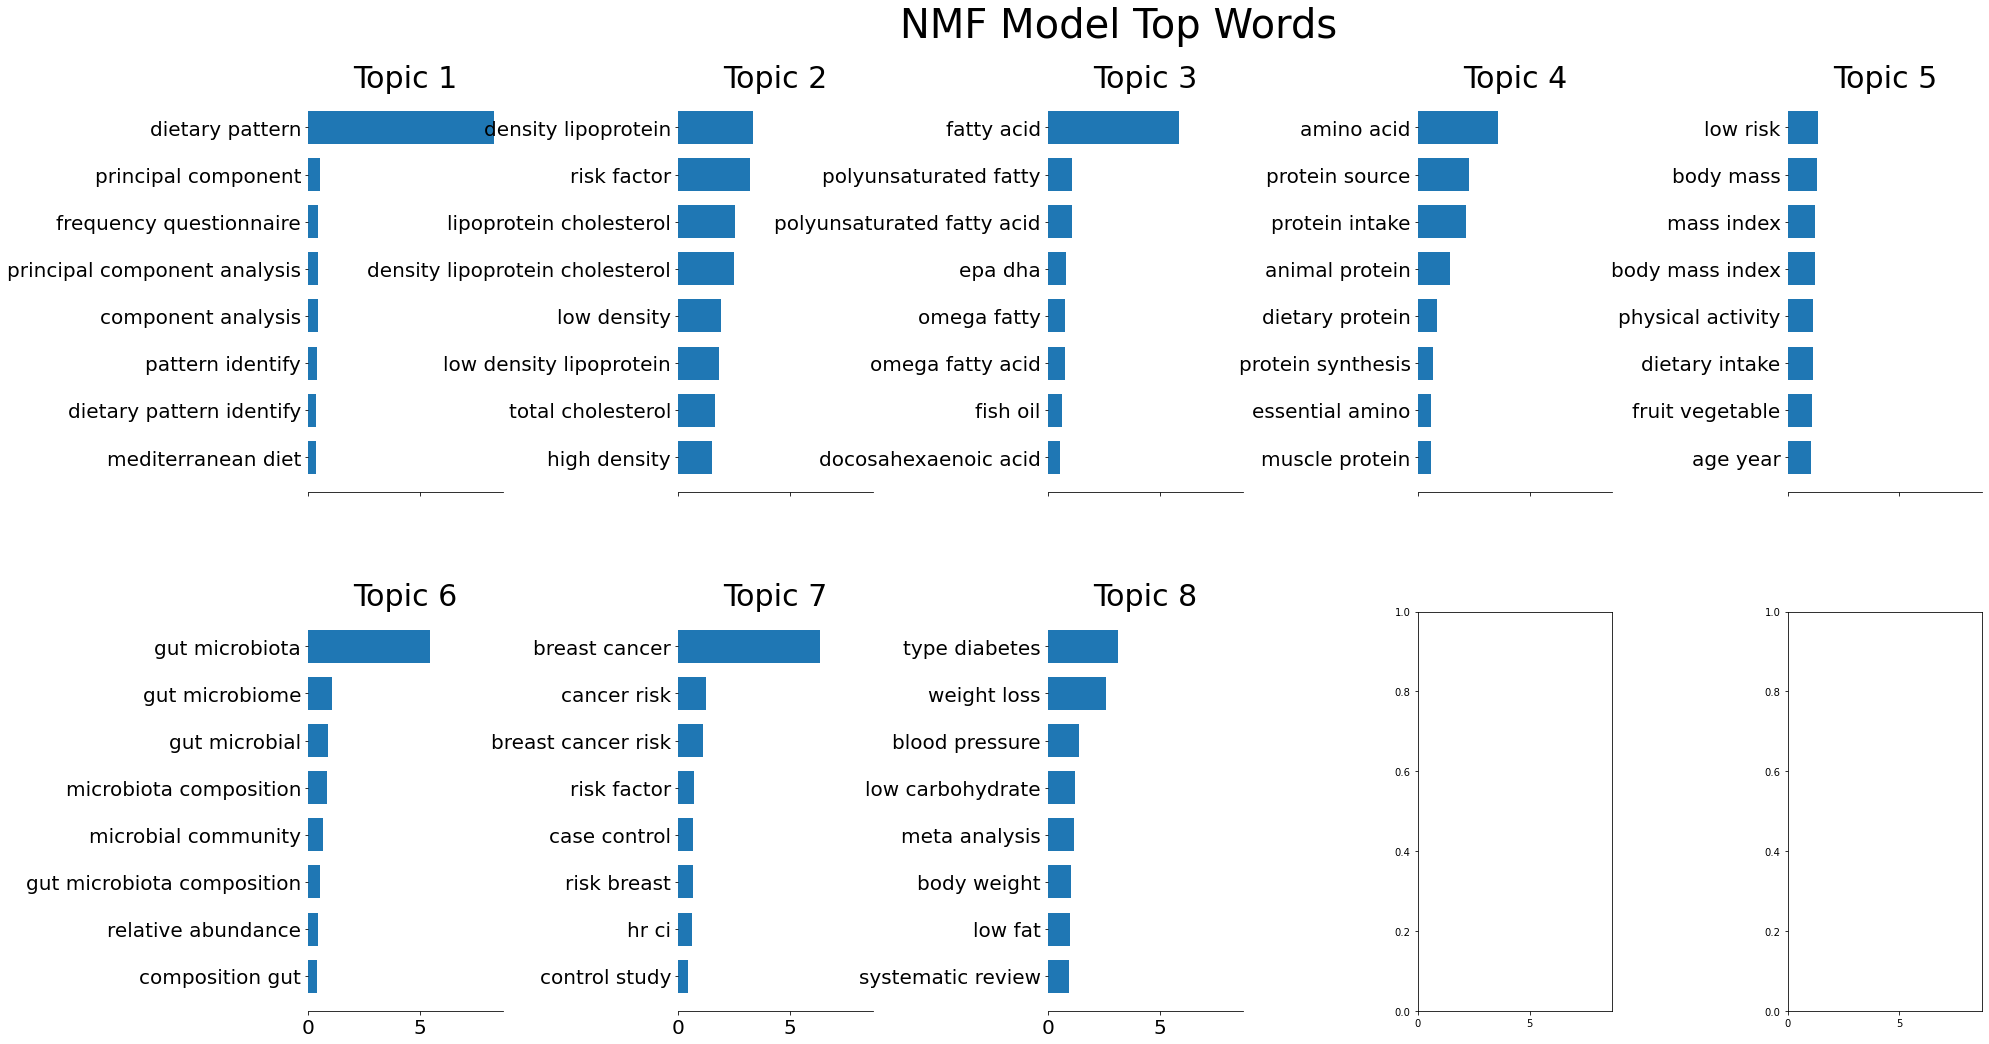

In [67]:

plot_top_words(nmf_model,nmf_feature_names,8,'NMF Model Top Words')

In [18]:
display_topics(nmf_model, cv.get_feature_names(), 10)
#                                                                   vs  removed additional words                                                             
# t 0 dietary pattern                                               food frequency questionnaire
# t 1 blood pressure body mass index and physical activity          bmi physical activity  vitamin deficiency 
# t2 omega 3 fatty acids                                              fatty acid 
# t3 amino acids                                               amino acids
# t4 cardiovascular                                               cardiovascular disease
# t5 gut microbiome                                                gut microbiota 
# t6 breast cancer                                                  breast cancer 
# t7 cholesterol ldl hdl                                               chelesterol ldl hdl  
# t8 weight loss mediterranean diet, carbohydrate diet, low carbohydrate diet    diabetes weight loss mediterranean diet
# t9 protein ghg emission                                                protein ghg emission 


Topic  0
dietary pattern, principal component, frequency questionnaire, component analysis, principal component analysis, pattern identify, dietary pattern identify, dietary intake, mediterranean diet, high fat

Topic  1
risk factor, blood pressure, body mass, mass index, body mass index, physical activity, cross sectional, age year, vitamin deficiency, fruit vegetable

Topic  2
fatty acid, polyunsaturated fatty, polyunsaturated fatty acid, epa dha, omega fatty, omega fatty acid, fish oil, docosahexaenoic acid, eicosapentaenoic acid, linolenic acid

Topic  3
protein intake, protein source, animal protein, dietary protein, total protein, protein diet, animal source, dietary intake, ghg emission, low protein

Topic  4
low risk, hr ci, diet index, diet quality, confidence interval, cardiovascular disease, frequency questionnaire, proportional hazard, cox proportional hazard, cox proportional

Topic  5
gut microbiota, gut microbiome, gut microbial, microbiota composition, microbial commun

In [19]:
#Creating a topic to document matrix

Vt_nmf = pd.DataFrame(doc_topic_nmf.round(5),
             index = docs,
             columns = ["component_0","component_1","component_2","component_3","component_4",
                       "component_5","component_6","component_7","component_8","component_9"])
Vt_nmf.head(2)

,component_0,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9
abstract_modeling,,,,,,,,,,
diet define include lacto ovo diet grow popularity western world reason include concern human health health planet diet sustainable meat diet reduce environmental impact include produce low level greenhouse gas emission dietary guideline formulate enhance health society reduce risk chronic disease prevent nutritional deficiency review scientific data diet summarize preventative therapeutic role cardiovascular disease cancer diabetes obesity osteoporosis consuming diet safe effective stage life cycle pregnancy lactation childhood old age diet high fiber polyphenolics diverse gut microbiota produce metabolite anti inflammatory function help manage disease process concern adequate intake number nutrient include vitamin calcium vitamin d iron zinc omega fat discuss use fortified supplement appropriate choice outline nutrient guideline suggest health professional work client consume diet,0.00819,0.02681,0.01606,0.0511,0.05013,0.16337,0.0012,0.02712,0.0,0.00000
aim study investigate prevalence attitude vegetarianism veganism assess vegetarianism veganism eat disorder depressive somatic symptom cross sectional questionnaire survey adult germany representative term age gender educational level carry data adult female include mean age sd year total participant report follow diet majority participant agree diet healthy harmless believe true diet majority participant believe diet lead nutritional deficiency female gender young age high education lower body mass index bmi high depressive eat disorder symptom vegetarianism veganism increased physical complaint group result point moderate prevalence vegetarianism veganism general population finding suggest health care professional eat disorder pathology affective status mind deal individual choose dietary pattern,0.11053,0.13920,0.00000,0.0000,0.00000,0.00230,0.0000,0.00000,0.0,0.00247


doc_topic_nmf = pd.DataFrame(doc_topic.round(5),
                             index = df['PaperID'],
                             columns = ["Depression","Diag. Psych. Disorder","Alc/Smoke_BMI","Tobacco Nat. Health",
                                        "ADHD_Suic.","Ment_Heal_Violence","Treatment","ADHD_Drug","PTSD"])
doc_topic_nmf




In [21]:
# df.head()

## t-SNE Visualization

In [ ]:
# create a threshold 
threshold = 0    # can do .02 or something similar

idx = np.amax(tfidf_text_topic_matrix, axis=1) > threshold
topics_matrix_filtered = tfidf_text_topic_matrix[idx]

In [ ]:
######## to find which one is this 
# create the text topic matrix from the word matrix
tfidf_text_topic_matrix = nmf.transform(tfidf_word_matrix)

In [ ]:
topics_matrix_filtered.shape

In [ ]:
# must Standard Scale the data before you fit_transform to perform ANY clustering!!
topics_matrix_std = StandardScaler().fit_transform(topics_matrix_filtered)

In [ ]:
tsne = TSNE(n_components=2, verbose=1, random_state=0, angle=.1, init='pca')
topics_mapped_2d = tsne.fit_transform(topics_matrix_std)

In [ ]:
# FILTERED topic with highest NMF value for each post
max_topic_per_post_list = []
for i in range(topics_matrix_filtered.shape[0]):
    max_topic_per_post_list.append(topics_matrix_filtered[i].argmax())

In [ ]:
max_topic_per_post = [[x] for x in max_topic_per_post_list]

tsne_data = np.concatenate((topics_mapped_2d, max_topic_per_post), 1)

In [ ]:
def cluster_plot(tsne_data, topic_labels):
    '''
    Plot the t-SNE cluster
    '''
    color_map = {0:  '#e6194b', 1:  '#3cb44b', 2:  '#ffe119', 3:  '#0082c8', 4:  '#f58231', 5:  '#911eb4',
                 6:  '#46f0f0', 7:  '#f032e6', 8:  '#d2f53c', 9:  '#fabebe', 10:  '#008080', 11:  '#e6beff',
                 12:  '#aa6e28', 13:  '#800000', 14:  '#aaffc3'}

    labels = list(range(nmf_n_compnents))

    plt.figure(figsize=(12, 8))
    for topic in range(nmf_n_compnents):
        inds = np.where(tsne_data[:, 2] == topic)[0]
        plt.scatter(x=tsne_data[inds, 0],
                    y=tsne_data[inds, 1],
                    marker='o',
                    s=10,
                    color=color_map[topic],
                    label=topic)

    plt.xlabel('Dimension 1', fontsize=12)
    plt.ylabel('Dimension 2', fontsize=12)
    plt.title('t-SNE Results: Topics in 2-D Space', fontsize=14)
    plt.legend(loc="lower left", labels=topic_labels, fontsize=12, prop={'size': 10}, markerscale=2)
    plt.show()

In [ ]:
cluster_plot(tsne_data, topic_list)

### NMF with TF-IDF

In [82]:
# 10 topics
nmf_model_tfidf = NMF(9)

In [83]:

doc_topic_nmftfidf = nmf_model_tfidf.fit_transform(abstracts_tfidf)

/Users/bingbingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [84]:
topic_word_nmf_tfidf = pd.DataFrame(nmf_model_tfidf.components_.round(5),
             index = ["component_0","component_1","component_2","component_3","component_4",
                     "component_5","component_6","component_7","component_8"],#"component_9"],
             columns = tfidf.get_feature_names())
topic_word_nmf_tfidf

,acetic acid,acid aa,acid ala,acid bacteria,acid bacteria lab,acid composition,acid concentration,acid content,acid dha,acid eicosapentaenoic,...,year old woman,year participate,year period,year study,year use,year year,young adult,young age,young child,young people
component_0,0.00000,0.00477,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.01003,0.00268,0.01733,0.00000,0.01897,0.00064,0.00459,0.00258
component_1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.01714,0.00000,0.00000,0.00000,...,0.02750,0.04272,0.02615,0.02463,0.02676,0.06925,0.06684,0.04976,0.02034,0.02876
component_2,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.06037,0.00000,0.04693,0.00878,0.00000,0.00142,0.02579,0.03059,0.03185,0.01703
component_3,0.06563,0.00000,0.00000,0.12536,0.06455,0.00000,0.00478,0.02484,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.01253,0.00504,0.00000,0.00000,0.00000,0.00000,0.00058
component_4,0.00000,0.00008,0.00011,0.03328,0.00638,0.00000,0.01061,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00858,0.00000,0.00000,0.00000,0.00465,0.00000
component_5,0.00000,0.05278,0.00000,0.05118,0.02541,0.09639,0.02072,0.03807,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00167,0.00000,0.00000,0.02519,0.00000,0.00245,0.00000
component_6,0.00368,0.00487,0.12441,0.00000,0.00000,0.10159,0.00102,0.03061,0.18685,0.09013,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
component_7,0.00000,0.00042,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00082,0.00000,0.00000,0.02201,0.00000,0.00993,0.00086,0.00025
component_8,0.00058,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00377,0.00182,0.00024,0.00000,0.00000,0.00028,0.00119,0.00095


In [85]:
display_topics(nmf_model_tfidf, tfidf.get_feature_names(), 10)   #15 topics.... vs 10 topics. I like 15 topipcs but there is one kind of overlap category 
#


Topic  0
dietary pattern, principal component, principal component analysis, component analysis, frequency questionnaire, fruit vegetable, mediterranean diet, pattern identify, dietary intake, dietary pattern identify

Topic  1
risk factor, blood pressure, body mass, mass index, body mass index, weight loss, physical activity, age year, type diabetes, cardiovascular disease

Topic  2
vitamin deficiency, year old, report case, vitamin level, serum vitamin, vitamin supplementation, present case, month old, vitamin status, failure thrive

Topic  3
natural product, bioactive compound, essential oil, anti inflammatory, cell line, oxidative stress, antioxidant activity, secondary metabolite, human health, cancer cell

Topic  4
gut microbiota, gut microbiome, microbiota composition, gut microbial, human gut, microbial community, relative abundance, human gut microbiota, rrna gene, gut microbiota composition

Topic  5
amino acid, protein source, protein intake, animal protein, dietary protein

In [77]:
#nmf with tfidf 10 words per topic
display_topics(nmf_model_tfidf, tfidf.get_feature_names(), 10)   #15 topics.... vs 10 topics. I like 15 topipcs but there is one kind of overlap category 
#

# NMF                                                                    vs   nmf tfidf 
# t 0 dietary pattern                                                               t0mediterranean diet  
# t 1 blood pressure body mass index and physical activity                               t1   blood pressure body weight cardiovascular.              
# t2 omega 3 fatty acids                                                     t2  vitamin deficiency 
# t3 amino acids                                                              t3 anti inflammatory antioxidant cancer cell                                               
# t4 cardiovascular                                                            t4 gut microbiome
# t5 gut microbiome                                                  t5 amino acid
# t6 breast cancer                                                  t6 fatty acid
# t7 cholesterol ldl hdl                                                  t7 respiratory syndrome 
# t8 weight loss mediterranean diet, carbohydrate diet, low carbohydrate diet     t8 recombinant protein
# t9 protein ghg emission                                                        t9 breast cancer physical activity 


Topic  0
dietary pattern, principal component, component analysis, principal component analysis, frequency questionnaire, fruit vegetable, diet quality, dietary intake, mediterranean diet, pattern identify

Topic  1
natural product, bioactive compound, essential oil, anti inflammatory, cell line, antioxidant activity, oxidative stress, human health, secondary metabolite, cancer cell

Topic  2
vitamin deficiency, year old, report case, vitamin level, serum vitamin, vitamin supplementation, present case, month old, vitamin status, failure thrive

Topic  3
recombinant protein, transient expression, nicotiana benthamiana, production recombinant, protein production, mammalian cell, production platform, production recombinant protein, cost effective, expression level

Topic  4
gut microbiota, gut microbiome, microbiota composition, gut microbial, human gut, microbial community, relative abundance, rrna gene, human gut microbiota, gut microbiota composition

Topic  5
amino acid, protein sour

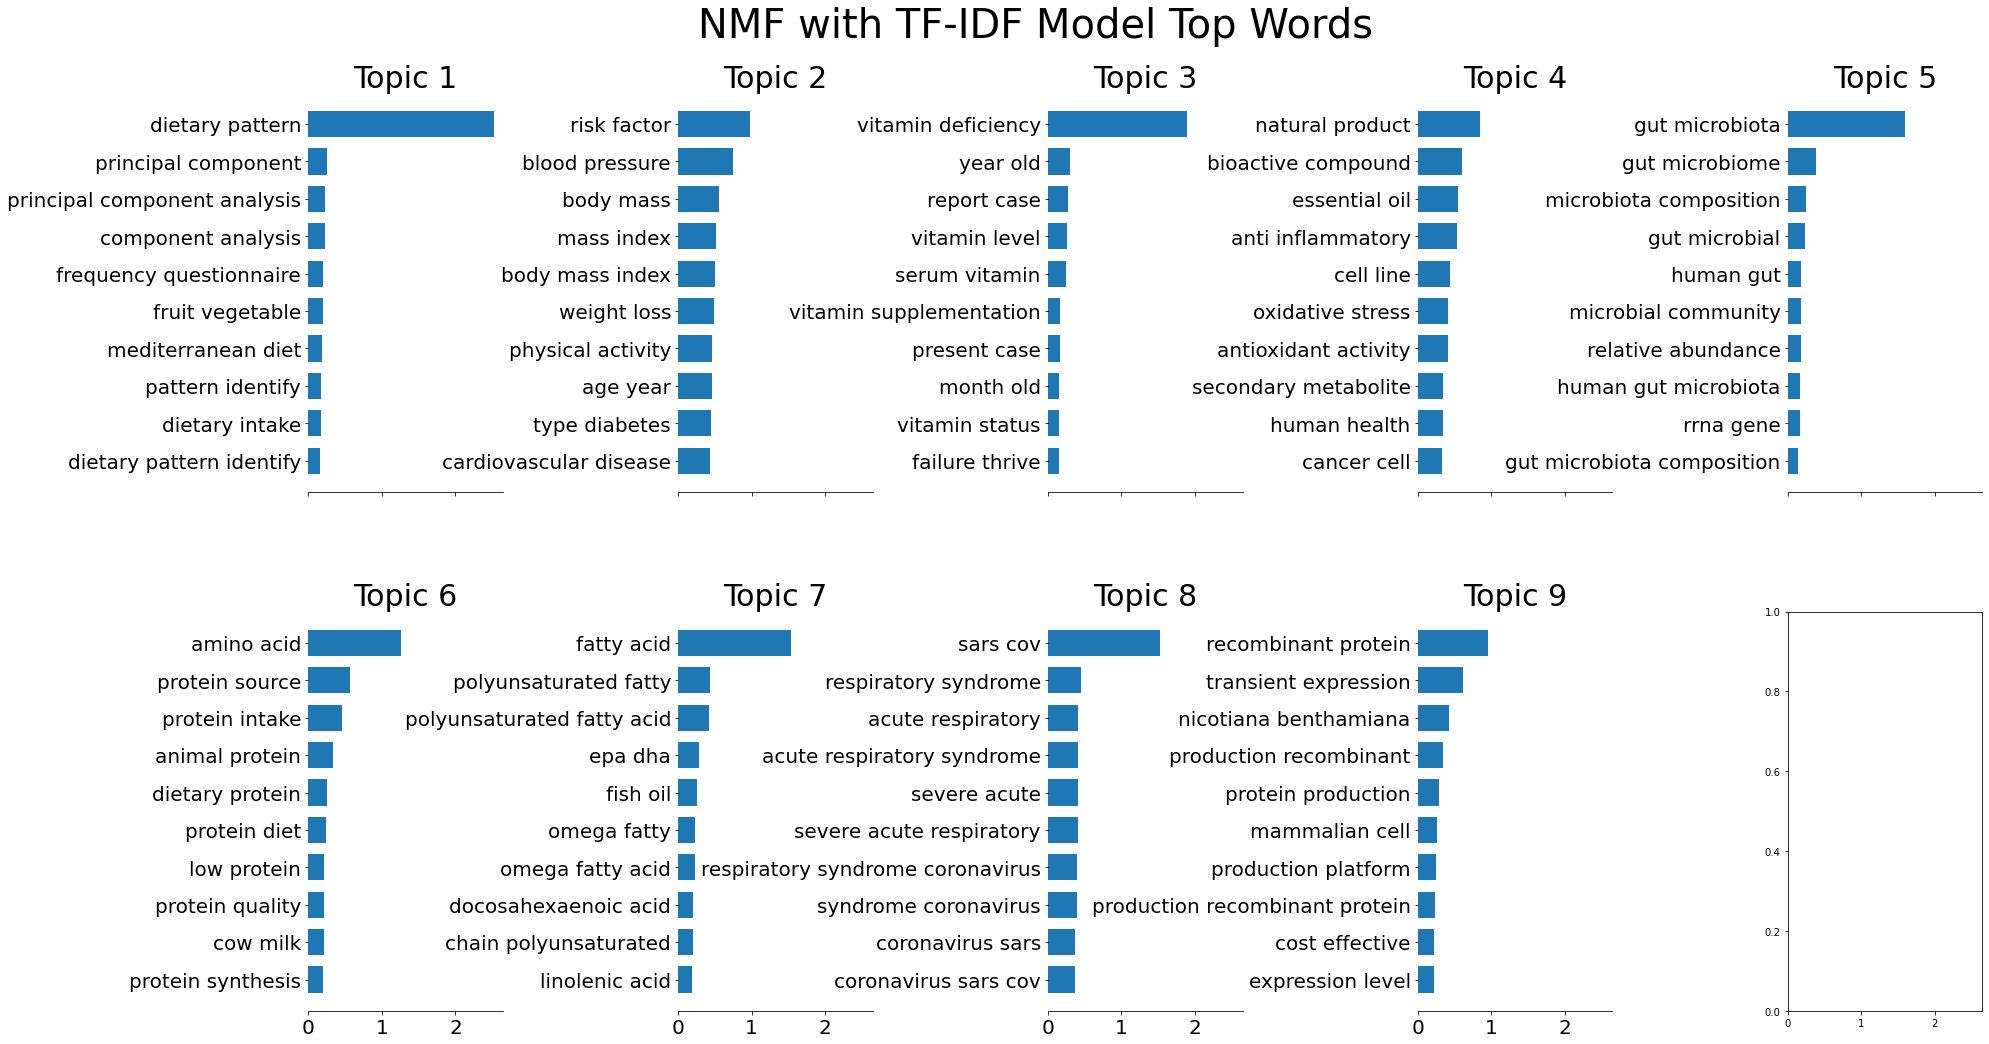

In [86]:
nmftfidf_feature_names = tfidf.get_feature_names()
plot_top_words(
    nmf_model_tfidf, nmftfidf_feature_names, 10, "NMF with TF-IDF Model Top Words             "
)
# https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html


In [88]:
#Creating a topic to document matrix

Vt_nmftfidf = pd.DataFrame(doc_topic_nmftfidf.round(5),
             index = docs,
             columns = ["component_0","component_1","component_2","component_3","component_4",
                       "component_5","component_6","component_7","component_8"]) #,"component_9"
Vt_nmftfidf.head(3)

,component_0,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8
abstract_modeling,,,,,,,,,
diet define include lacto ovo diet grow popularity western world reason include concern human health health planet diet sustainable meat diet reduce environmental impact include produce low level greenhouse gas emission dietary guideline formulate enhance health society reduce risk chronic disease prevent nutritional deficiency review scientific data diet summarize preventative therapeutic role cardiovascular disease cancer diabetes obesity osteoporosis consuming diet safe effective stage life cycle pregnancy lactation childhood old age diet high fiber polyphenolics diverse gut microbiota produce metabolite anti inflammatory function help manage disease process concern adequate intake number nutrient include vitamin calcium vitamin d iron zinc omega fat discuss use fortified supplement appropriate choice outline nutrient guideline suggest health professional work client consume diet,0.00883,0.01854,0.00311,0.02165,0.063,0.01663,0.00689,0.00297,0.0
aim study investigate prevalence attitude vegetarianism veganism assess vegetarianism veganism eat disorder depressive somatic symptom cross sectional questionnaire survey adult germany representative term age gender educational level carry data adult female include mean age sd year total participant report follow diet majority participant agree diet healthy harmless believe true diet majority participant believe diet lead nutritional deficiency female gender young age high education lower body mass index bmi high depressive eat disorder symptom vegetarianism veganism increased physical complaint group result point moderate prevalence vegetarianism veganism general population finding suggest health care professional eat disorder pathology affective status mind deal individual choose dietary pattern,0.02680,0.04354,0.00102,0.00000,0.000,0.00000,0.00000,0.00000,0.0
health authority recommend diet rich fruit vegetable pulse grain nut low red meat moderate dairy egg poultry fish beneficial health environment systematic review observational intervention study publish january conduct assess nutrient intake status adult population consume diet meat mean intake nutrient calculate benchmarked dietary reference value micronutrient status mean concentration biomarkers calculate compare diet group total study include europe south east asia north america protein intake lower people follow diet compare meat recommend intake level fiber polyunsaturated fatty acid pufa folate vitamin c e magnesium intake high eicosapentaenoic acid epa docosahexaenoic acid dha intake low compare meat intake status vitamin vitamin d iron zinc iodine calcium bone turnover marker low dietary pattern compare meat low vitamin calcium iodine intake low iodine status low bone mineral density meat risk inadequate intake fiber pufa α linolenic acid ala folate vitamin d e calcium magnesium nutrient inadequacy dietary pattern include meat diet diet good health environment public health strategy facilitate transition balance diet diverse nutrient dense consumer education fortification supplementation,0.04093,0.01567,0.00550,0.00000,0.000,0.01467,0.10394,0.00000,0.0


In [89]:
doc_topic_nmftfidf = pd.DataFrame(doc_topic_nmftfidf.round(5),
                             index = df['pmc'],
                             columns = ["Dietary_Pattern","Risk_Factor","Vitamin","Human_Health",
                                        "Gut","Protein_Source","Omega_Profile","Respiratory","Recombinant_Protein"])#,"Ingredient"
doc_topic_nmftfidf

,Dietary_Pattern,Risk_Factor,Vitamin,Human_Health,Gut,Protein_Source,Omega_Profile,Respiratory,Recombinant_Protein
pmc,,,,,,,,,
8623061,0.00883,0.01854,0.00311,0.02165,0.06300,0.01663,0.00689,0.00297,0.00000
7176641,0.02680,0.04354,0.00102,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
8746448,0.04093,0.01567,0.00550,0.00000,0.00000,0.01467,0.10394,0.00000,0.00000
6412408,0.00594,0.00916,0.00149,0.00112,0.00128,0.00890,0.00331,0.00081,0.00000
5622783,0.00355,0.03972,0.00000,0.00000,0.00157,0.01169,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...
7600377,0.01300,0.03333,0.01015,0.00000,0.00352,0.00000,0.00000,0.00000,0.00003
7502407,0.00060,0.00757,0.01679,0.01999,0.00413,0.00110,0.00000,0.00000,0.00229
4425151,0.00000,0.04062,0.02906,0.00000,0.00000,0.00000,0.00031,0.00000,0.00000



## [LSA](#fifth-bullet) <a class="anchor" id="fifth-bullet"></a>


## 2. Latent Semantic Analysis (LSA)
### LSA with CountVec

https://openclassrooms.com/en/courses/5869986-perform-an-exploratory-data-analysis/6172111-analyze-the-results # graph ideas

In [30]:
lsa_model = TruncatedSVD(10)

doc_topic_lsa = lsa_model.fit_transform(abstracts_cv)  #fit onto vectorized data

lsa_var_ratio=lsa_model.explained_variance_ratio_
lsa_var_ratio

array([0.02742035, 0.01144748, 0.01031226, 0.01010142, 0.00846175,
       0.0076435 , 0.00738909, 0.00704215, 0.00667147, 0.00639779])

In [31]:

#                     # "component_10","component_11","component_12","component_13","component_14"
#This shows you what each term is likely to be in
topic_word_lsa = pd.DataFrame(lsa_model.components_.round(3),
             index = ["component_0","component_1","component_2","component_3","component_4",
                     "component_5","component_6","component_7","component_8","component_9"],
             columns = cv.get_feature_names())   #use name of vectorizer 'cv'
topic_word_lsa.head(3)


,acetic acid,acid aa,acid ala,acid bacteria,acid bacteria lab,acid composition,acid concentration,acid content,acid dha,acid eicosapentaenoic,...,year old woman,year participate,year period,year study,year use,year year,young adult,young age,young child,young people
component_0,0.000,0.002,0.002,0.002,0.000,0.004,0.002,0.001,0.003,0.001,...,0.000,0.002,0.003,0.002,0.004,0.002,0.009,0.002,0.001,0.002
component_1,0.002,0.004,0.014,0.003,0.001,0.027,0.009,0.007,0.020,0.009,...,0.002,0.008,0.005,0.003,0.005,0.009,0.011,0.004,0.002,0.001
component_2,-0.001,-0.008,-0.023,-0.007,-0.002,-0.059,-0.005,-0.016,-0.034,-0.018,...,0.002,0.004,0.005,0.002,0.003,0.007,-0.003,0.003,0.000,0.001


In [34]:
display_topics(lsa_model, cv.get_feature_names(), 10) # lsa vs nmf+tfidf  


Topic  0
dietary pattern, risk factor, frequency questionnaire, dietary intake, fruit vegetable, cardiovascular disease, age year, low risk, fatty acid, cross sectional

Topic  1
fatty acid, risk factor, blood pressure, type diabetes, density lipoprotein, protein intake, body mass, amino acid, cardiovascular disease, weight loss

Topic  2
risk factor, blood pressure, density lipoprotein, lipoprotein cholesterol, density lipoprotein cholesterol, breast cancer, body mass, mass index, body mass index, low density

Topic  3
amino acid, protein intake, protein source, animal protein, dietary protein, protein synthesis, essential amino, muscle protein, essential amino acid, protein diet

Topic  4
density lipoprotein, lipoprotein cholesterol, density lipoprotein cholesterol, gut microbiota, low density, low density lipoprotein, amino acid, dietary pattern, blood pressure, total cholesterol

Topic  5
density lipoprotein, fatty acid, breast cancer, lipoprotein cholesterol, density lipoprotein 

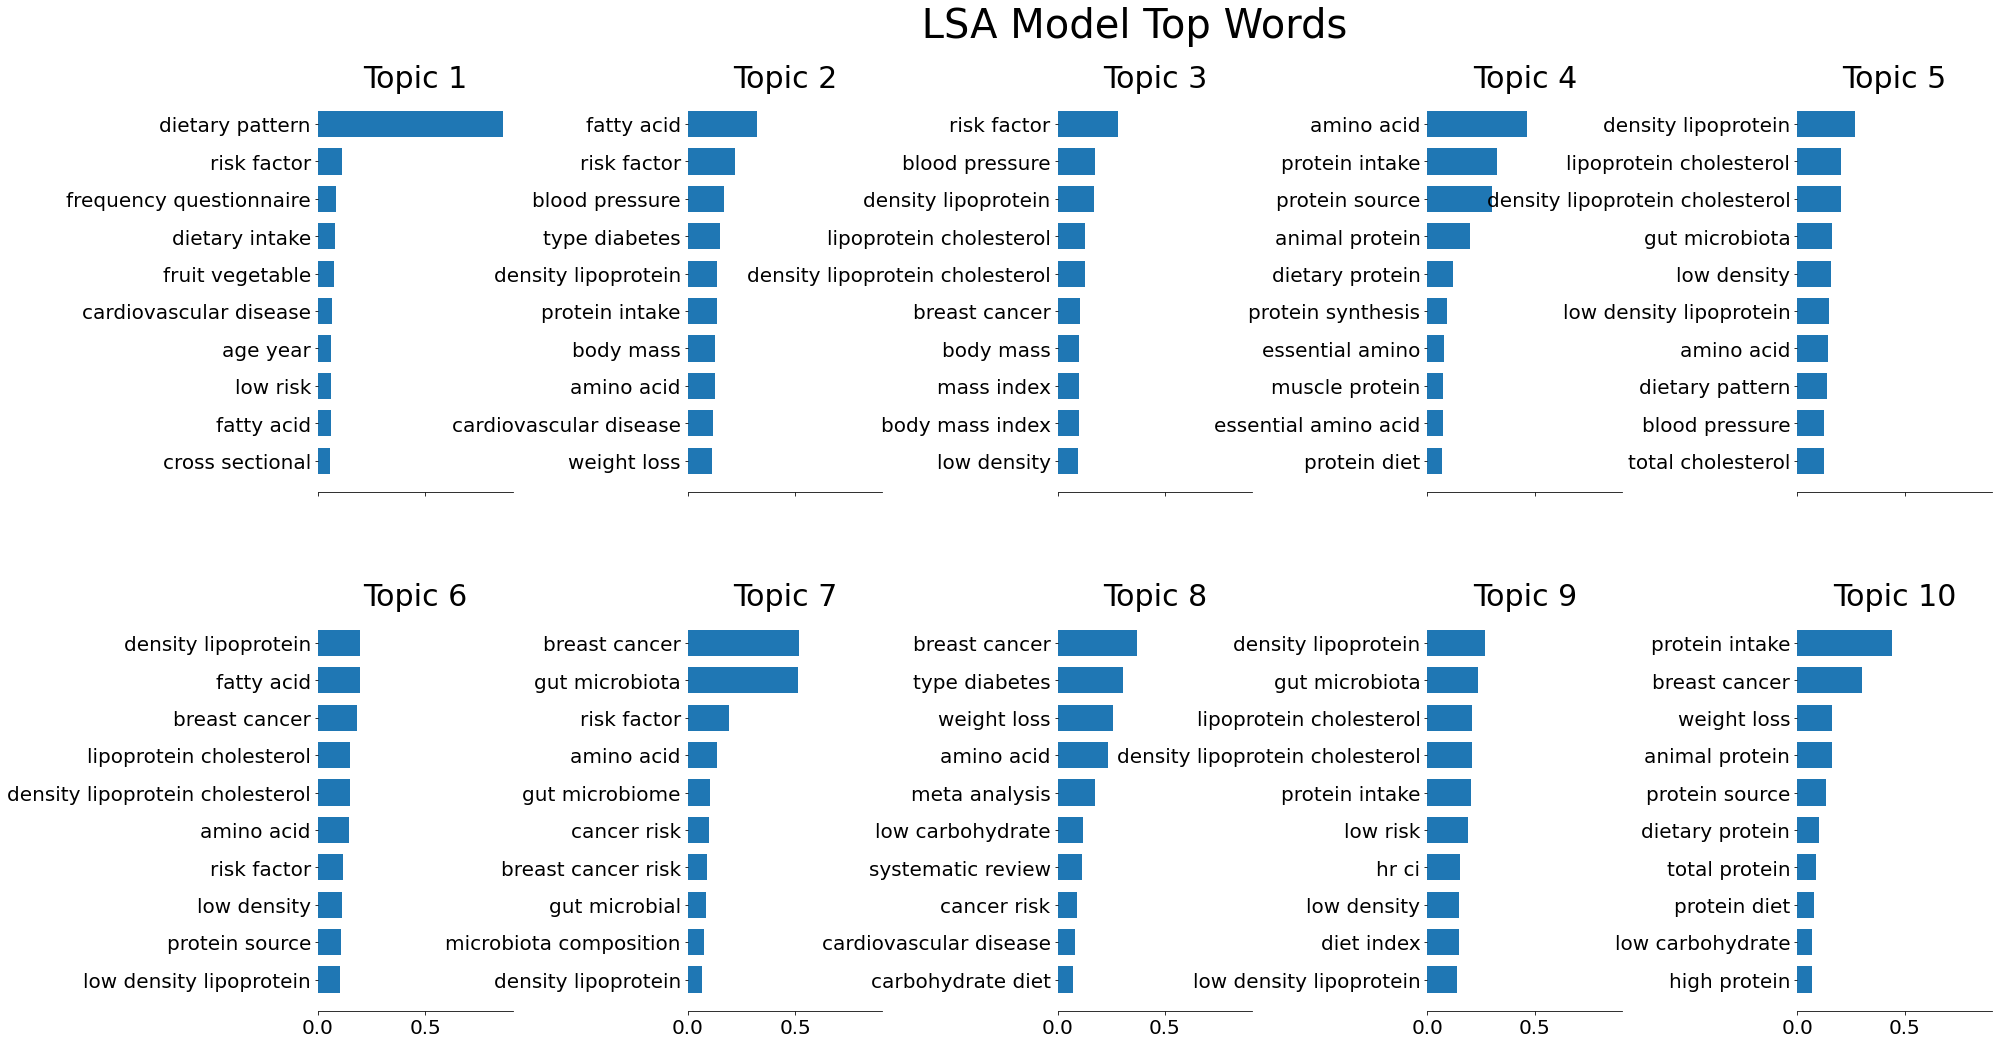

In [36]:
lsa_feature_names = cv.get_feature_names()
plot_top_words(
    lsa_model, lsa_feature_names, 10, " LSA Model Top Words"
)
# https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html



In [37]:
#Creating a topic to document matrix

Vt_lsa = pd.DataFrame(doc_topic_lsa.round(5),
             index = docs,
             columns = ["component_0","component_1","component_2","component_3","component_4",
                       "component_5","component_6","component_7","component_8","component_9"])
Vt_lsa.head(1)

,component_0,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9
abstract_modeling,,,,,,,,,,
diet define include lacto ovo diet grow popularity western world reason include concern human health health planet diet sustainable meat diet reduce environmental impact include produce low level greenhouse gas emission dietary guideline formulate enhance health society reduce risk chronic disease prevent nutritional deficiency review scientific data diet summarize preventative therapeutic role cardiovascular disease cancer diabetes obesity osteoporosis consuming diet safe effective stage life cycle pregnancy lactation childhood old age diet high fiber polyphenolics diverse gut microbiota produce metabolite anti inflammatory function help manage disease process concern adequate intake number nutrient include vitamin calcium vitamin d iron zinc omega fat discuss use fortified supplement appropriate choice outline nutrient guideline suggest health professional work client consume diet,0.44544,0.6988,-0.12955,0.02286,0.02826,-0.99768,0.35778,-0.32462,0.3092,-0.06973


## LSA with TF-IDF

In [38]:
lsa_model_tfidf = TruncatedSVD(10)

doc_topic_lsatfidf = lsa_model_tfidf.fit_transform(abstracts_tfidf)  #fit onto vectorized data

lsa_model_var_ratio=lsa_model_tfidf.explained_variance_ratio_

In [33]:
#This shows you what each term is likely to be in
topic_word_lsatfidf = pd.DataFrame(lsa_model_tfidf.components_.round(5),
             index = ["component_0","component_1","component_2","component_3","component_4",
                     "component_5","component_6","component_7","component_8","component_9",
                     # "component_10","component_11","component_12","component_13","component_14"
                     ],
             columns = tfidf.get_feature_names())   #use name of vectorizer 'cv'
topic_word_lsatfidf.head(1)

/Users/bingbingzhang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,acetic acid,acid aa,acid ala,acid bacteria,acid bacteria lab,acid composition,acid concentration,acid content,acid dha,acid eicosapentaenoic,...,year old woman,year participate,year period,year study,year use,year year,young adult,young age,young child,young people
component_0,0.00509,0.00628,0.01027,0.01429,0.00557,0.01453,0.00609,0.0066,0.01327,0.00557,...,0.00628,0.00537,0.00734,0.00685,0.00876,0.00926,0.01899,0.00928,0.00688,0.0058


In [39]:
display_topics(lsa_model_tfidf, tfidf.get_feature_names(), 10)                 # I still prefer NMF tfidf             



Topic  0
dietary pattern, fatty acid, risk factor, gut microbiota, dietary intake, fruit vegetable, cardiovascular disease, age year, blood pressure, amino acid

Topic  1
dietary pattern, principal component, principal component analysis, component analysis, frequency questionnaire, pattern identify, diet quality, dietary pattern identify, hr ci, pattern high

Topic  2
vitamin deficiency, year old, report case, vitamin level, serum vitamin, vitamin supplementation, present case, vitamin status, month old, failure thrive

Topic  3
sars cov, dietary pattern, natural product, recombinant protein, transient expression, respiratory syndrome, vitamin deficiency, acute respiratory syndrome, acute respiratory, severe acute respiratory

Topic  4
gut microbiota, dietary pattern, gut microbiome, vitamin deficiency, amino acid, microbiota composition, gut microbial, microbial community, human gut, relative abundance

Topic  5
amino acid, protein source, protein intake, animal protein, dietary pro

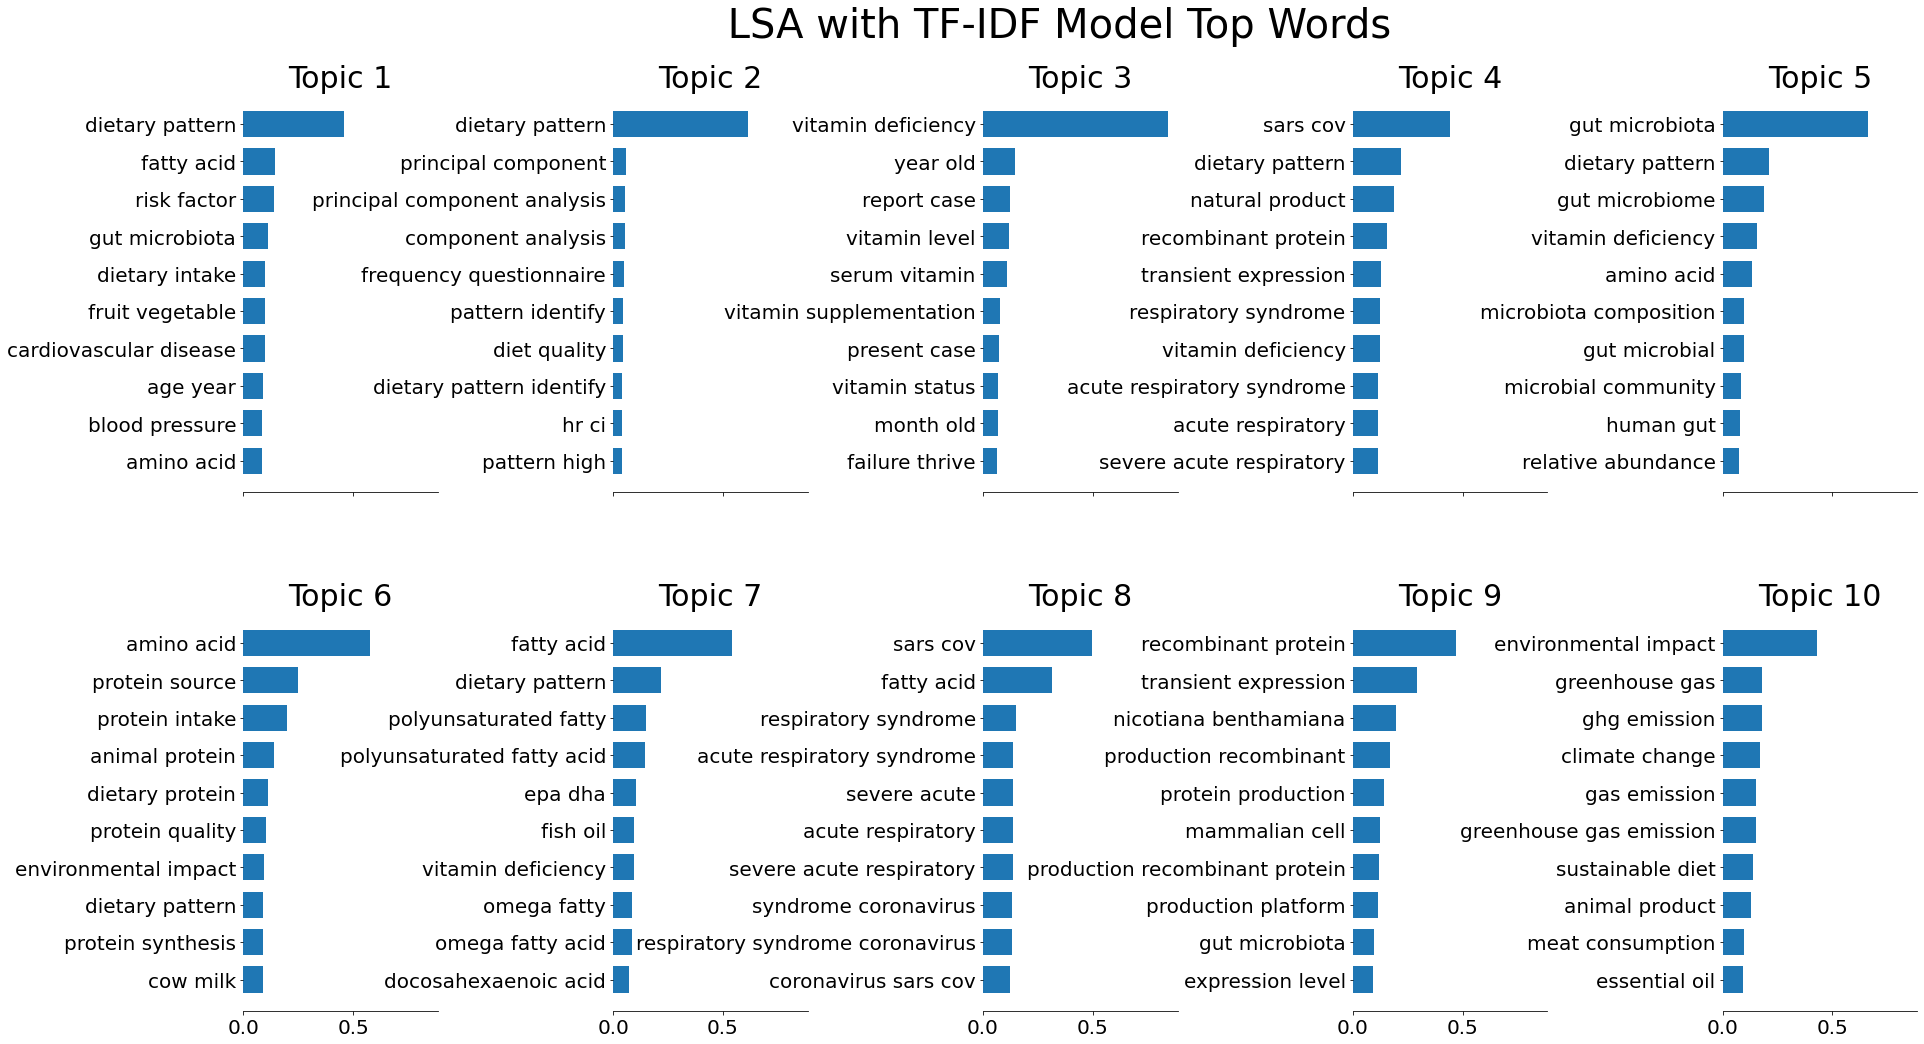

In [40]:
lsa_feature_names_tfidf = tfidf.get_feature_names()
plot_top_words(
    lsa_model_tfidf, lsa_feature_names_tfidf, 10, " LSA with TF-IDF Model Top Words"
)
# https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html




In [42]:
#Creating a topic to document matrix

Vt_lsatfidf = pd.DataFrame(doc_topic_lsatfidf.round(5),
             index = docs,
             columns = ["component_0","component_1","component_2","component_3","component_4",
                       "component_5","component_6","component_7","component_8","component_9"])
Vt_lsatfidf.head(1)

,component_0,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9
abstract_modeling,,,,,,,,,,
diet define include lacto ovo diet grow popularity western world reason include concern human health health planet diet sustainable meat diet reduce environmental impact include produce low level greenhouse gas emission dietary guideline formulate enhance health society reduce risk chronic disease prevent nutritional deficiency review scientific data diet summarize preventative therapeutic role cardiovascular disease cancer diabetes obesity osteoporosis consuming diet safe effective stage life cycle pregnancy lactation childhood old age diet high fiber polyphenolics diverse gut microbiota produce metabolite anti inflammatory function help manage disease process concern adequate intake number nutrient include vitamin calcium vitamin d iron zinc omega fat discuss use fortified supplement appropriate choice outline nutrient guideline suggest health professional work client consume diet,0.14152,-0.06618,-0.02722,0.00251,0.0758,-0.02926,-0.03913,-0.00624,-0.01777,0.22318


## LDA <a class="anchor" id="sixth-bullet"></a>
## 3. Latent Dirichlet Allocation
### LDA with CountVectorizer

In [43]:
# Create the term-document matrix
# Transpose the count vectorizer matrix it so the terms are the rows
doc_word_lda = abstracts_cv.transpose()

doc_word_lda.shape

(3457, 3684)

In [44]:
# Convert to gensim
# Convert sparse matrix of counts to a gensim corpus
corpus_lda = matutils.Sparse2Corpus(doc_word_lda)

In [45]:
# Map matrix rows to words (tokens)
# We need to save a mapping (dict) of row id to word (token) for later use by gensim
id2word = dict((v, k) for k, v in cv.vocabulary_.items())
#len(id2word)

In [39]:
len(id2word)

/Users/bingbingzhang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


3503

In [46]:
# Create lda model (equivalent to "fit" in sklearn)
lda_model = models.LdaModel(corpus=corpus_lda, num_topics=10, id2word=id2word, passes=5)

[(0,
  '0.013*"dietary pattern" + 0.011*"associate low" + 0.009*"low risk" + 0.009*"dietary intake" + 0.008*"frequency questionnaire" + 0.007*"hr ci" + 0.006*"age year" + 0.006*"confidence interval" + 0.006*"high intake" + 0.006*"associate low risk"'),
 (1,
  '0.014*"natural product" + 0.011*"sars cov" + 0.011*"bioactive compound" + 0.010*"recombinant protein" + 0.008*"secondary metabolite" + 0.008*"immune response" + 0.007*"transient expression" + 0.007*"human health" + 0.007*"present study" + 0.006*"cost effective"'),
 (2,
  '0.031*"fatty acid" + 0.022*"gut microbiota" + 0.008*"antioxidant activity" + 0.006*"prostate cancer" + 0.006*"polyunsaturated fatty" + 0.006*"epa dha" + 0.006*"microbiota composition" + 0.006*"polyunsaturated fatty acid" + 0.006*"phenolic compound" + 0.006*"fish oil"'),
 (3,
  '0.015*"density lipoprotein" + 0.012*"risk factor" + 0.010*"meta analysis" + 0.010*"lipoprotein cholesterol" + 0.010*"density lipoprotein cholesterol" + 0.010*"low density" + 0.010*"year old" + 0.009*"low density lipoprotein" + 0.009*"systematic review" + 0.008*"total cholesterol"'),
 (4,
  '0.019*"protein intake" + 0.014*"animal protein" + 0.012*"blood pressure" + 0.011*"protein diet" + 0.008*"dairy product" + 0.008*"kidney disease" + 0.007*"control group" + 0.007*"fruit vegetable" + 0.007*"low protein" + 0.006*"protein source"'),
 (5,
  '0.063*"dietary pattern" + 0.010*"principal component" + 0.010*"pattern associate" + 0.009*"principal component analysis" + 0.008*"component analysis" + 0.008*"cow milk" + 0.007*"dietary pattern associate" + 0.007*"increase risk" + 0.005*"diet quality" + 0.005*"oxygen specie"'),
 (6,
  '0.020*"cell line" + 0.019*"essential oil" + 0.017*"anti inflammatory" + 0.009*"anti cancer" + 0.008*"growth factor" + 0.007*"experimental diet" + 0.007*"gut microbiome" + 0.007*"dietary fibre" + 0.007*"ferulic acid" + 0.007*"cell death"'),
 (7,
  '0.015*"cardiovascular disease" + 0.012*"type diabetes" + 0.012*"mediterranean diet" + 0.012*"dietary pattern" + 0.010*"risk factor" + 0.008*"fatty acid" + 0.007*"chronic disease" + 0.007*"clinical trial" + 0.007*"fruit vegetable" + 0.007*"diabetes mellitus"'),
 (8,
  '0.013*"breast cancer" + 0.011*"weight loss" + 0.011*"cross sectional" + 0.010*"body mass" + 0.008*"risk factor" + 0.008*"mass index" + 0.008*"body mass index" + 0.007*"lacto ovo" + 0.006*"insulin resistance" + 0.006*"sectional study"'),
 (9,
  '0.023*"amino acid" + 0.017*"vitamin deficiency" + 0.016*"protein source" + 0.011*"environmental impact" + 0.008*"iron deficiency" + 0.008*"animal product" + 0.007*"greenhouse gas" + 0.007*"climate change" + 0.006*"dietary guideline" + 0.006*"ghg emission"')]

In [47]:
lda_model.print_topics(10)

# t0     food frequency questionnaire
# t1     metabolic protein
# t2   gut microme  antioxidant acticity prostate cancer epa dha 
# t3   cholesterol ldl 
# t4   protein. animal blooy proterin. kidney disease 
# t5   pca dietary pattern
# t6   anti inflammatory anti cancer gut microbiome dietary fibre
# t7   cvd diabetes mediterranean 
# t8   breast cancer body mass index. 
# t9   vitamin deficiency environmental impact climate change greenhouse gas

[(0,
  '0.018*"blood pressure" + 0.011*"risk factor" + 0.010*"gut microbiome" + 0.009*"weight loss" + 0.009*"insulin resistance" + 0.009*"density lipoprotein" + 0.008*"body mass" + 0.007*"body weight" + 0.007*"lipoprotein cholesterol" + 0.007*"density lipoprotein cholesterol"'),
 (1,
  '0.019*"cardiovascular disease" + 0.016*"type diabetes" + 0.010*"risk factor" + 0.010*"weight loss" + 0.007*"long term" + 0.006*"low carbohydrate" + 0.006*"low risk" + 0.006*"crude extract" + 0.006*"hr ci" + 0.005*"western blot"'),
 (2,
  '0.023*"gut microbiota" + 0.015*"amino acid" + 0.015*"vitamin deficiency" + 0.012*"protein source" + 0.008*"animal protein" + 0.008*"red meat" + 0.007*"microbiota composition" + 0.006*"microbial community" + 0.006*"birth weight" + 0.006*"cow milk"'),
 (3,
  '0.016*"natural product" + 0.012*"systematic review" + 0.012*"environmental impact" + 0.010*"meta analysis" + 0.009*"clinical trial" + 0.008*"methanolic extract" + 0.007*"drug discovery" + 0.007*"greenhouse gas" + 0.

lda_feature_names = cv.get_feature_names()  # does not work
plot_top_words(
    lda_model, lda_feature_names, 10, " LDA Model Top Words"
)
# https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html



### LDA with TF-IDF

In [50]:
# Create the term-document matrix
# Transpose the count vectorizer matrix it so the terms are the rows
doc_word_ldatfidf = abstracts_tfidf.transpose()

doc_word_ldatfidf.shape

(3457, 3684)

In [51]:
# Convert to gensim
# Convert sparse matrix of counts to a gensim corpus
corpus_ldatfidf = matutils.Sparse2Corpus(doc_word_ldatfidf)

In [53]:
# Map matrix rows to words (tokens)
# We need to save a mapping (dict) of row id to word (token) for later use by gensim
id2word_tfidf = dict((v, k) for k, v in tfidf.vocabulary_.items())

In [45]:
len(id2word)

/Users/bingbingzhang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


3503

In [54]:
# Create lda model (equivalent to "fit" in sklearn)
lda_model_tfidf = models.LdaModel(corpus=corpus_ldatfidf, num_topics=10, id2word=id2word_tfidf, passes=5)

In [55]:
lda_model_tfidf.print_topics(10)
#   lda vs lda tfidf 

# t0     food frequency questionnaire
# t1     metabolic protein
# t2   gut microme  antioxidant acticity prostate cancer epa dha 
# t3   cholesterol ldl 
# t4   protein. animal blooy proterin. kidney disease 
# t5   pca dietary pattern
# t6   anti inflammatory anti cancer gut microbiome dietary fibre
# t7   cvd diabetes mediterranean 
# t8   breast cancer body mass index. 
# t9   vitamin deficiency environmental impact climate change greenhouse gas


# t0 anticancer property, dietary supplementart
# t1 prostate cancer protein resource antioxidant amino acid 
# t2 vitamin deficiency gut microbiome 
# t3 blood pressure weight loss body mass 
# t4 essential oil anti cancer 
# t5 gut microbiome 
# t6 drug discover 
# t7 fatty acid 
# t8 protein source acids
# t9 breast cancer questionnaire

[(0,
  '0.008*"antimicrobial activity" + 0.007*"ethyl acetate" + 0.007*"stable isotope" + 0.006*"inhibitory concentration" + 0.006*"fish feed" + 0.006*"recombinant human" + 0.005*"escherichia coli" + 0.005*"anticancer activity" + 0.005*"study reveal" + 0.005*"drug resistance"'),
 (1,
  '0.006*"pseudomonas aeruginosa" + 0.006*"vitro vivo" + 0.006*"study demonstrate" + 0.005*"mammalian cell" + 0.005*"carbon source" + 0.005*"large scale" + 0.005*"central nervous" + 0.005*"fatty acid" + 0.004*"demonstrate potential" + 0.004*"herbal medicine"'),
 (2,
  '0.008*"high performance" + 0.007*"natural product" + 0.007*"human health" + 0.006*"aqueous extract" + 0.005*"cow milk" + 0.005*"liquid chromatography" + 0.005*"phenolic compound" + 0.005*"performance liquid" + 0.005*"essential oil" + 0.005*"western blot"'),
 (3,
  '0.006*"blood pressure" + 0.005*"hr ci" + 0.005*"cell wall" + 0.005*"water content" + 0.004*"increase expression" + 0.004*"chain fatty" + 0.004*"chain fatty acid" + 0.004*"aim stud

lsa_feature_names_tfidf = tfidf.get_feature_names()
plot_top_words(
    lsa_model_tfidf, lsa_feature_names_tfidf, 10, " LDA with TF-IDF Model Top Words"
)
# https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html




## CorEx <a class="anchor" id="seventh-bullet"></a>



## CorEx

doc_word
cv= vectorizer
abstract_cv=doc_word


#nmf
cv = CountVectorizer(ngram_range=(1, 2), min_df=0.005, max_df=1.0, stop_words='english', binary=True)
abstracts_cv = cv.fit_transform(docs)

# 15 topics
nmf_model = NMF(15)
doc_topic = nmf_model.fit_transform(abstracts_cv)

/Users/bingbingzhang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,pmc,title,abstract,abstract_modeling
0,PMC8623061,The Safe and Effective Use of Plant-Based Die...,"Plant-based diets, defined here as including ...","[plant, base, diet, define, include, vegan, la..."
1,PMC7176641,Prevalence and psychopathology of vegetarians...,The aim of the study was to investigate the p...,"[aim, study, investigate, prevalence, attitude..."
2,PMC8746448,Nutrient Intake and Status in Adults Consumin...,Health authorities increasingly recommend a m...,"[health, authority, recommend, plant, base, di..."


In [56]:
cv = CountVectorizer(max_features=20000,ngram_range=(2, 3), min_df=10,max_df=0.8,
                             stop_words=my_stop_words,# token_pattern="\\b[a-z][a-z]+\\b",
                             binary=False)

doc_word_corex = cv.fit_transform(docs)
words_corex = list(np.asarray(cv.get_feature_names()))

/Users/bingbingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['based', 'community', 'dietary', 'identify', 'microbial', 'pattern', 'version', 'µg'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [57]:
# n_hidden is the number of topics
# words is your list of words used in your corpus
# I recommend adding docs=df.data to make it easier to check which sentences are in each resulting topic ## need to check 
corex_model = ct.Corex(n_hidden=10, words=words_corex, seed=1)
corex_model.fit(doc_word_corex, words=words_corex, docs=df.abstract_modeling)

In [58]:
topics = corex_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))

#     topic 1 lofistic regresion
#     topic 2 cardiovascular diaseases and diabetes, kidney diseases
#     topic 3 bmi blood pressure cholesterol LDL 
#     topic 4 acids omega 3 
#     topic 5 anti inflammatory cancer cell antioxidant 
#     topic 6 pa risk factor
#     topic 7 dietarity pattern and nutrient intake
#     topic 8 gut microbiome acids ghg environmental impact     
#     topic 9
    
# t1 questionnaire
# t2 bmi 
# t2 cardiocascular disease blood pressure acid 
# t3 mediterranean diet kidney disease 
# t4 pca physical activity 
# t5 cancer cell antioxidant 
# t6 
# t7 amino acid environmental impact ghg emission 
# t8 gut microbiota anti inflammatory fatty acid
# t9 viramin deficiency respiratory 

0: dietary pattern, frequency questionnaire, confidence interval, interval ci, confidence interval ci, low risk, health study, component analysis, principal component analysis, principal component
1: age year, dietary intake, physical activity, regression model, linear regression, men woman, age sex, nutrient intake, self report, study population
2: body mass, mass index, body mass index, blood pressure, mass index bmi, index bmi, density lipoprotein, total cholesterol, risk factor, low density lipoprotein
3: fatty acid, polyunsaturated fatty, polyunsaturated fatty acid, protein intake, animal protein, protein diet, dietary protein, kidney disease, low protein, chronic kidney disease
4: type diabetes, control trial, systematic review, trial registration, meta analysis, clinical trial, clinicaltrials gov, web science, mediterranean diet, randomize control
5: natural product, bioactive compound, antioxidant activity, essential oil, cell line, natural compound, traditional medicine, cance

0: participant,conclusion,age,association,dietary,ci,intake,questionnaire,regression,objective
1: expression,cell,activity,induce,gene,anti,molecular,food,meat,mechanism
2: plant,vegetarian,base,diet,vegan,property,compound,omnivore,vitamin,potential
3: extract,strain,chemical,leaf,chromatography,water,inhibitory,antimicrobial,bacteria,obesity
4: disease,patient,diabetes,cardiovascular,clinical,inflammatory,therapy,cancer,treatment,chronic
5: sustainable,product,consumer,use,environmental,demand,challenge,market,sustainability,alternative
6: supplementary,version,authorized,online,electronic,user,sequence,rrna,available,material
7: review,compare,search,discuss,focus,scientific,literature,medicinal,medicine,high
8: acid,gut,fatty,microbiota,microbiome,composition,amino,metabolic,intestinal,feed
9: formation,arabidopsis,thaliana,performance,ro,propose,transcriptomic,silver,larvae,larva

????
topic_model = ct.Corex(n_hidden=10, words=words,
                       max_iter=2000, verbose=False, seed=1)

topic_model.fit(doc_word, words=words, docs=df.abstract, 
                anchors=[['body mass','bmi'], 
                         ['plant','vegetarian']
                         ['questionnaire'], 
                         ['fat'],
                         ['supplementary']
                         ['sustainable','environmental']
                         ['cancer','tumor']
                         ['disease','cardiovascular']
                         ['gut','microbiome']], anchor_strength=2)

# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

In [185]:
# Let's check out topic : sustainable 
corex_model.get_top_docs(topic=8, n_docs=1)

[(['plant',
   'base',
   'diet',
   'define',
   'include',
   'vegan',
   'lacto',
   'ovo',
   'vegetarian',
   'diet',
   'grow',
   'popularity',
   'western',
   'world',
   'reason',
   'include',
   'concern',
   'human',
   'health',
   'health',
   'planet',
   'plant',
   'base',
   'diet',
   'sustainable',
   'meat',
   'base',
   'diet',
   'reduce',
   'environmental',
   'impact',
   'include',
   'produce',
   'low',
   'level',
   'greenhouse',
   'gas',
   'emission',
   'dietary',
   'guideline',
   'formulate',
   'enhance',
   'health',
   'society',
   'reduce',
   'risk',
   'chronic',
   'disease',
   'prevent',
   'nutritional',
   'deficiency',
   'review',
   'scientific',
   'data',
   'plant',
   'base',
   'diet',
   'summarize',
   'preventative',
   'therapeutic',
   'role',
   'cardiovascular',
   'disease',
   'cancer',
   'diabetes',
   'obesity',
   'osteoporosis',
   'consuming',
   'plant',
   'base',
   'diet',
   'safe',
   'effective',
   'stag

In [59]:
# Note, instead of using .predict(doc_word), you can also call topic_model.labels
predictions = pd.DataFrame(corex_model.predict(doc_word_corex), columns=['topic'+str(i) for i in range(10)])
predictions.head(3)

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9
0,False,True,False,True,False,False,False,False,True,True
1,False,True,True,False,False,False,False,True,False,False
2,True,True,True,True,True,False,False,True,False,True


How do I determine how many topics I should have?
The makers of CorEx have a created a cool plotting function to see what the TC of each topic is.
Look for an elbow (either at 1 topic or 4 topics) and you can create a cut-off there

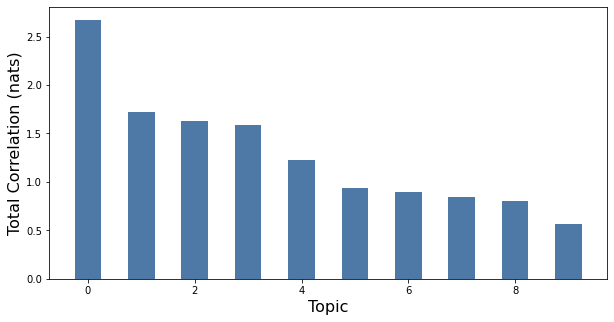

In [60]:
plt.figure(figsize=(10,5))
plt.bar(range(corex_model.tcs.shape[0]), corex_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);
plt.savefig('corex9topics5min.png')

<3684x3515 sparse matrix of type '<class 'numpy.float64'>'
	with 78089 stored elements in Compressed Sparse Row format>

cv = CountVectorizer(max_features=20000,ngram_range=(2, 3), min_df=10,max_df=0.8,
                             stop_words=my_stop_words,# token_pattern="\\b[a-z][a-z]+\\b",
                             binary=False)

doc_word = cv.fit_transform(docs)
words = list(np.asarray(cv.get_feature_names()))

# n_hidden is the number of topics
# words is your list of words used in your corpus
# I recommend adding docs=df.data to make it easier to check which sentences are in each resulting topic ## need to check 
corex_model = ct.Corex(n_hidden=10, words=words, seed=1)
corex_model.fit(doc_word, words=words, docs=df.abstract_modeling)

topics = corex_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))




## Recommendar System <a class="anchor" id="eighth-bullet"></a>

#vectorize in the context of our model
vt = tfidf.transform(input_)   #use TFIDF

In [ ]:
abstracts_tfidf.shape

#topics for NMFmodel 
tt = nmf_model.transform(vt)   #LSA model



In [ ]:
## NMF TFIDF recommendar 

nmf_model = NMF(10)
nmf_model.fit(abstracts_tfidf)
doc_topic = nmf_model.transform(abstracts_tfidf)

topic_word = pd.DataFrame(nmf_model.components_.round(5),
             index = ["component_0","component_1","component_2","component_3","component_4",
                     "component_5","component_6","component_7","component_8","component_9"],
             columns = tfidf.get_feature_names())
topic_word.head(3)

doc_topic_lsa = pd.DataFrame(doc_topic.round(5),
                             index = df_4['PaperID'],
                             columns = ["Depression","Diag. Psych. Disorder","Alc/Smoke_BMI","Tobacco Nat. Health",
                                        "ADHD_Suic.","Ment_Heal_Violence","Treatment","ADHD_Drug","PTSD"])
doc_topic_lsa

In [ ]:
def recommender(string): 
    text =[string]
    vt = tfidf.transform(text)
    tt = nmf_model_tfidf.transform(vt)
    print(tt)
    recs = pairwise_distances(tt,doc_topic_nmftfidf,metric='cosine').argsort()
    top5=recs[0][0:5].tolist()
    
    top5_papers=[]
    for x in top5: 
        paper_row = df.loc[x]
        top5_papers.append(paper_row['pmc']) 
    print(top5_papers)    
    #return top5_papers

In [ ]:
doc_topic_nmftfidf

In [90]:
def recommender(string): 
    text =[string]
    vt = tfidf.transform(text)
    tt = nmf_model_tfidf.transform(vt)
    print(tt)
    recs = pairwise_distances(tt,doc_topic_nmftfidf,metric='cosine').argsort()
    top5=recs[0][0:5].tolist()
    
    top5_papers=[]
    for x in top5: 
        paper_row = df.loc[x]
        top5_papers.append(paper_row['pmc']) 
    print(top5_papers)    
    #return top5_papers

In [91]:
recommender('breast cancer and weight loss and body mass index')

[[0.         0.08834367 0.         0.         0.         0.
  0.         0.         0.        ]]
['6579433', '3610945', '1247209', '4281478', '5967136']


In [93]:
df[df['pmc'] == '6579433']

,pmc,title,abstract,abstract_modeling
2665,6579433,Dietary and Lifestyle Changes Reverses Hypert...,Objectives: Hypertension increases cardiovasc...,objective hypertension increase cardiovascular...


In [96]:
df['abstract'][2665]

' Objectives: Hypertension increases cardiovascular disease mortality; it is worldwide; and it is the number one cause for medical interventions in the U.S. We tested the effectiveness of reversing systolic blood pressure (SBP) in older adults by an intensive lifestyle of a wholefoods vegan diet together with other health principles of the Adventist Lifestyle that prevents hypertension. Methods: This is a retrospective 2-week pretest-posttest analysis in 1132 hypertensive men and women (mean\xa0±\xa0SD: 64.0\xa0±\xa012.3, SBP 143\xa0±\xa022 mmHg) enrolled consecutively from 1988 to 1999 in an 18-day medically operated health improvement program, NEWSTART (Nutrition, Exercise, Water, Sunlight, Temperance—moderation and no addictive substances as tobacco or alcohol—fresh Air, Rest, and Trust [spirituality/relationships]). The whole-foods vegan diet had 26% of energy as fat and 1193 mg sodium/1000 calories. Data was analyzed by paired t-test using SPSS Statistics. Results: SBP dropped sig

In [97]:
df[df['pmc'] == '3610945']

,pmc,title,abstract,abstract_modeling
1298,3610945,"Changes in anthropometric measurements, body ...",Objective: The purpose of this study was to d...,objective purpose study change anthropometric ...


In [98]:
df['abstract'][1298]

" Objective: The purpose of this study was to describe changes in anthropometric measurements, body composition, blood pressure, lipid profile, and testosterone following a low–energy-density dietary intervention plus regimented supplementation program. Methods: The study design was a pre-post intervention design without a control group. Normal participants were recruited from the faculty, staff, students, and community members from a chiropractic college to participate in a 21-day weight loss program. All participants (n = 49; 36 women, 13 men; 31 ± 10.3 years of age) received freshly prepared mostly vegan meals (breakfast, lunch, and dinner) that included 1200 to 1400 daily calories (5020.8 to 5857.6 J) for the women and 1600 to 1800 (6694.4 to 7531.2 J) daily calories for the men. Nutritional supplements containing enzymes that were intended to facilitate digestion, reduce cholesterol levels, increase metabolic rate, and mediate inflammatory processes were consumed 30 minutes before

In [99]:
df[df['pmc'] == '1247209'] #'1247209', 

,pmc,title,abstract,abstract_modeling
692,1247209,Plasma lipids and lipoprotein cholesterol con...,Concentrations of total cholesterol and chole...,concentration total cholesterol cholesterol li...


In [105]:
df['abstract'][692]

' Concentrations of total cholesterol and cholesterol in the various lipoprotein fractions were measured in vegans, vegetarians, fish eaters (who did not eat meat), and meat eaters. Total and low density lipoprotein cholesterol concentrations were higher in meat eaters than vegans, with vegetarians and fish eaters having intermediate and similar values. High density lipoprotein cholesterol concentration was highest in the fish eaters but did not differ among the other groups. There were striking trends with age in total and low density lipoprotein cholesterol concentrations, which differed between men and women: women showed a steady increase in concentration with age, whereas concentrations in men did not increase appreciably after the age of 40, which may partly explain sex differences in the prevalence of coronary heart disease. The differences in total cholesterol concentration suggest that the incidence of coronary heart disease may be 24% lower in lifelong British vegetarians and

In [104]:
df[df['pmc'] == '4281478']

,pmc,title,abstract,abstract_modeling
2284,4281478,"Physical Activity, Hormone Replacement Therap...",Background: Atherosclerotic calcification is ...,background atherosclerotic calcification risk ...


In [103]:
df['abstract'][2284]

' Background: Atherosclerotic calcification is a risk factor for cardiovascular events, independent of other traditional risk factors. Studies of the relation of menopausal hormone therapy to cardiovascular events have had inconsistent results, and often have been confounded by lifestyle behaviors and the “healthy user” effect. The authors evaluated the cross-sectional association of hormone therapy use with the presence and severity of atherosclerosis in postmenopausal women, independent of lifestyle factors, including diet and physical activity levels. Methods: The authors consecutively enrolled postmenopausal asymptomatic women who were referred for coronary artery calcium scanning to measure cardiovascular risk. After consent was obtained, women were interviewed prior to their cardiac scan about cardiac risk factors, hormone therapy use, menopausal status, diet, and physical activity. Coronary artery calcium prevalence was defined as any calcification present (score >0). Results: O

In [101]:
df[df['pmc'] == '5967136'] 

,pmc,title,abstract,abstract_modeling
468,5967136,Prevalence of Metabolic Syndrome and Framingh...,Background: Recent studies have shown a lower...,background recent study low prevalence metabol...


In [102]:
df['abstract'][468]

' Background: Recent studies have shown a lower prevalence of metabolic syndrome (MSyn) in vegetarians (VEG) despite the inconclusive evidence from others. Objective: To verify the association between diet and other lifestyle characteristics and the prevalence of MSyn, cardiovascular risk factors (CRF), and Framingham Risk Score (FRS) in apparently healthy VEG and omnivorous (OMN) men. Methods: In this cross-sectional study, 88 apparently healthy men ≥ 35 years, 44 VEG and 44 OMN, were assessed for anthropometric data, blood pressure, blood lipids, glucose, C-reactive protein (CRP) and FRS. To test the association between lifestyle and MSyn, Student t test, chi-square test, and multiple logistic regression model were used. A significance level of 5% was considered in all statistical analyses. Results: Several CRF were significantly lower in VEG than in OMN: body mass index, systolic blood pressure, diastolic blood pressure, fasting serum total cholesterol, LDL-cholesterol, apolipoprote


# Write function to ouput Paper ID's of similar articles

def recommender(string): 
    text =[string]
    vt = tfidf.transform(text)
    tt = nmf_model.transform(vt)
    print(tt)
    recs = pairwise_distances(tt,doc_topic,metric='cosine').argsort()
    top5=recs[0][0:5].tolist()
    
    top5_papers=[]
    for x in top5: 
        paper_row = df_4.loc[x]
        top5_papers.append(paper_row['PaperID']) 
    print(top5_papers)    
    #return top5_papers
    

In [ ]:

recommender('breast cancer and weight loss')

In [56]:
df.head(2)

/Users/bingbingzhang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,pmc,title,abstract,abstract_modeling
0,8623061,The Safe and Effective Use of Plant-Based Die...,"Plant-based diets, defined here as including ...","diet, define, include, lacto, ovo, diet, grow,..."
1,7176641,Prevalence and psychopathology of vegetarians...,The aim of the study was to investigate the p...,"aim, study, investigate, prevalence, attitude,..."


In [84]:
# 10 topics
nmf_model = NMF(10)
nmf_model.fit(abstracts_cv)
doc_topic = nmf_model.transform(abstracts_cv)

topic_word = pd.DataFrame(nmf_model.components_.round(5),
             index = ["component_0","component_1","component_2","component_3","component_4",
                     "component_5","component_6","component_7","component_8","component_9"],
             columns = cv.get_feature_names())
topic_word.head(3)

/Users/bingbingzhang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/bingbingzhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


,acetic acid,acid aa,acid ala,acid bacteria,acid bacteria lab,acid composition,acid concentration,acid content,acid dha,acid eicosapentaenoic,...,year old woman,year participate,year period,year study,year use,year year,young adult,young age,young child,young people
component_0,0.00000,0.01037,0.0000,0.00973,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00062,0.00730,0.00277,0.00000,0.03936,0.00155,0.00327,0.01228
component_1,0.00271,0.00327,0.0000,0.00000,0.00047,0.00000,0.07955,0.00338,0.00000,0.00000,...,0.02455,0.07146,0.03359,0.05522,0.01357,0.14757,0.14252,0.08004,0.04092,0.03051
component_2,0.00752,0.02814,0.2749,0.01596,0.00054,0.36966,0.00510,0.04947,0.39696,0.20125,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [85]:
# Take a user input
input_ = ['prevention for diabetes and breast cancer']

/Users/bingbingzhang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [86]:
#vectorize in the context of our model
vt = cv.transform(input_)   #use TFIDF

vt

/Users/bingbingzhang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<1x3515 sparse matrix of type '<class 'numpy.int64'>'
	with 1 stored elements in Compressed Sparse Row format>

In [ ]:
vt.shape

In [53]:
abstracts_tfidf.shape

/Users/bingbingzhang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(3684, 18234)

In [87]:
#topics for model 
tt = nmf_model.transform(vt)   #nmf model


/Users/bingbingzhang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [56]:
tt.shape  # 9 Topics

/Users/bingbingzhang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(1, 10)

/Users/bingbingzhang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/bingbingzhang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [97]:
df.reset_index(inplace=False)

/Users/bingbingzhang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [98]:
df

/Users/bingbingzhang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,index,pmc,title,abstract,abstract_modeling
0,0,8623061,The Safe and Effective Use of Plant-Based Die...,"Plant-based diets, defined here as including ...","[plant, base, diet, define, include, vegan, la..."
1,1,7176641,Prevalence and psychopathology of vegetarians...,The aim of the study was to investigate the p...,"[aim, study, investigate, prevalence, attitude..."
2,2,8746448,Nutrient Intake and Status in Adults Consumin...,Health authorities increasingly recommend a m...,"[health, authority, recommend, plant, base, di..."
3,3,6412408,"Insect Consumption Attitudes among Vegans, No...",Abstract: Background: Consumption of foods of...,"[abstract, background, consumption, food, inse..."
4,4,5622783,Comparison of Sociodemographic and Nutritiona...,Background: There is a growing trend for vege...,"[background, grow, trend, vegetarian, vegan, d..."
...,...,...,...,...,...
3679,34302,7600377,Dietary Quality Changes According to the Prec...,One-year dietary quality change according to ...,"[year, dietary, quality, change, accord, prece..."
3680,49600,7502407,Prepectoral implant pocket conversion in brea...,Introduction: While many authors have reporte...,"[introduction, author, report, experience, imm..."
3681,55935,4425151,Low Maternal Vitamin B12 Status Is Associated...,Background and Aims: Studies in South Asian p...,"[background, aims, study, south, asian, popula..."
3682,56017,8150303,Potential Health Benefits Associated with Lun...,"Lunasin has demonstrated antioxidative, anti-...","[lunasin, demonstrate, antioxidative, anti, in..."


In [99]:
def recommender(string): 
    text =[string]
    vt = cv.transform(text)
    tt = nmf_model.transform(vt)
    print(tt)
    recs = pairwise_distances(tt,doc_topic,metric='cosine').argsort()
    top5=recs[0][0:5].tolist()
    
    top5_papers=[]
    for x in top5: 
        paper_row = df.loc[x]
        top5_papers.append(paper_row['pmc']) 
    print(top5_papers)    
    #return top5_papers

/Users/bingbingzhang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [101]:
recommender('amino acid in physical activity for questionnaire')

# end of this jupyter notebook csv or zip file... save the resulting model... 

# database_ on the cloud or AWS clever cloud open your cloud and then link the link the data to your web application within 

#save the results of the recommendar systems.. and open it in this file 

# make your app and make sure it runs well on local .. 

# save the end model... from this jupyter notebook 

[[0.         0.01682288 0.         0.15769802 0.         0.
  0.00110179 0.         0.         0.        ]]
['6950041', '7257918', '5931979', '7851820', '4705437']


/Users/bingbingzhang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [92]:
print(top5_papers)

NameError: name 'top5_papers' is not defined

In [102]:
df[df['pmc'] == '6950041']

/Users/bingbingzhang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,index,pmc,title,abstract,abstract_modeling
201,213,6950041,A Comparison of Dietary Protein Digestibility...,Vegetarian diets provide an abundance of nutr...,"[vegetarian, diet, provide, abundance, nutrien..."


In [103]:
df['abstract'][201]

/Users/bingbingzhang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


' Vegetarian diets provide an abundance of nutrients when carefully planned. However, vegetarian diets may have lower protein quality compared to omnivorous diets, a reflection of less favorable amino acid profiles and bioavailability. Hence, the current recommended dietary allowance for protein may not be adequate for some vegetarian populations. The purpose of this study was to determine dietary protein quality using the DIAAS (Digestible Indispensable Amino Acid Score) method in vegetarian and omnivore endurance athletes. DIAAS scores reflect the true ileal digestibility of the indispensable amino acids that are present in food items, and these scores can be used to compute the available protein in diet plans. Thirty-eight omnivores and 22 vegetarians submitted seven-day food records that were analyzed for nutrient content, and DIAAS scores were computed by diet group. Average available protein (g) was compared along with participants’ lean body mass and strength (quantified using t

In [90]:
df['title'][992]

/Users/bingbingzhang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


' The association between soya consumption and serum thyroid-stimulating hormone concentrations in the Adventist Health Study-2.'


Topic  0 blood pressure 
group, vegetarian, body, conclusion, difference, compare, blood, measure, age, participant

Topic  1 drug and treatment
compound, activity, drug, extract, plant base, plant, cell, treatment, natural, potential

Topic  2 supplementary
material available, supplementary material available, supplementary material, online version, supplementary, contain supplementary, contain supplementary material, version, online version article, version article

Topic  3 environmental and sustainable 
environmental, health, food, sustainable, research, animal, knowledge, future, survey, provide

Topic  4 diabetes and cardiovascular diseases
disease, review, evidence, cardiovascular, chronic, diabetes, cardiovascular disease, plant base diet, diet, base diet

Topic  5 questionnaire
association, ci, food frequency, regression, associate, frequency, questionnaire, food frequency questionnaire, frequency questionnaire, cohort

Topic  6 vitamin deficiency
deficiency, vitamin, vitamin deficiency, case, patient, old, vegetarian, year old, month, year

Topic  7 virus antibody and protein vaccine
expression, vaccine, production, recombinant, produce, virus, express, antibody, protein, transient

Topic  8 gut microbime
gut, microbiota, microbial, gene, gut microbiota, bacterial, abundance, composition, diversity, microbiome

Topic  9 ingredient 
content, product, protein, acid, property, ingredient, source, food, plant, plant base

In [103]:
topic_word = pd.DataFrame(nmf_model.components_.round(3),
             index = ["component_0","component_1","component_2","component_3","component_4",
                     "component_5","component_6","component_7","component_8","component_9"],
             columns = tfidf.get_feature_names())
topic_word

/Users/bingbingzhang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,aa,aa profile,ab,abdominal,abdominal obesity,abdominal pain,aberrant,ability,ability plant,abiotic,...,µg ml µg,µm,µmol,κb,μg,μg fresh,μg ml,μl,μm,μmol
component_0,0.020,0.000,0.003,0.023,0.017,0.000,0.001,0.017,0.000,0.000,...,0.001,0.000,0.016,0.000,0.032,0.000,0.005,0.003,0.000,0.025
component_1,0.005,0.000,0.001,0.003,0.000,0.006,0.011,0.052,0.008,0.004,...,0.011,0.011,0.001,0.012,0.062,0.000,0.067,0.005,0.017,0.005
component_2,0.000,0.000,0.000,0.004,0.004,0.000,0.000,0.001,0.000,0.000,...,0.000,0.004,0.000,0.000,0.009,0.005,0.007,0.000,0.007,0.000
component_3,0.000,0.000,0.001,0.005,0.000,0.002,0.000,0.014,0.000,0.005,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
component_4,0.002,0.003,0.000,0.008,0.001,0.000,0.001,0.003,0.002,0.000,...,0.000,0.000,0.000,0.004,0.000,0.000,0.000,0.001,0.000,0.000
component_5,0.006,0.000,0.000,0.007,0.000,0.000,0.000,0.004,0.000,0.000,...,0.000,0.000,0.000,0.002,0.000,0.000,0.000,0.000,0.000,0.000
component_6,0.000,0.000,0.001,0.012,0.000,0.010,0.000,0.000,0.000,0.000,...,0.000,0.000,0.018,0.000,0.024,0.000,0.000,0.001,0.000,0.015
component_7,0.000,0.000,0.015,0.000,0.000,0.000,0.000,0.051,0.007,0.007,...,0.000,0.004,0.000,0.000,0.022,0.020,0.000,0.000,0.002,0.000
component_8,0.001,0.000,0.000,0.002,0.001,0.000,0.000,0.041,0.001,0.007,...,0.000,0.004,0.000,0.002,0.000,0.000,0.000,0.000,0.001,0.001
component_9,0.025,0.017,0.000,0.000,0.000,0.000,0.000,0.045,0.002,0.000,...,0.001,0.000,0.000,0.000,0.005,0.004,0.000,0.002,0.014,0.002


In [105]:
doc_topic_nmf = pd.DataFrame(doc_topic.round(5),
                             index = df['pmc'],
                             columns = ["Blood_Pressure","Drug_and_treaatment","Supplementary","environmental_and_sustainable",
                                        "Diabetes_and_Cardiovascular_disease","Questionnaire","Vitamin_deficiency","Virus_and_antibody","Gut_microbiome","Ingredient"])
doc_topic_nmf

/Users/bingbingzhang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Blood_Pressure,Drug_and_treaatment,Supplementary,environmental_and_sustainable,Diabetes_and_Cardiovascular_disease,Questionnaire,Vitamin_deficiency,Virus_and_antibody,Gut_microbiome,Ingredient
pmc,,,,,,,,,,
8623061,4.32881,0.22194,-2.95547,-0.45209,0.89719,0.59361,0.61645,-1.39509,0.27098,-0.16558
7176641,3.52840,3.17526,0.24845,-0.42672,-0.07777,-0.37777,1.47148,-0.60687,0.11751,0.26260
8746448,4.48793,1.56454,-2.42008,0.15468,2.04208,-0.69241,-0.50908,-0.57644,-0.46228,-1.00607
6412408,2.82450,0.75879,0.33512,0.70296,0.72813,-0.88113,1.07520,0.04394,-0.10499,0.61680
5622783,4.93591,2.58155,-0.00290,1.00296,0.13433,-1.17558,0.85069,-0.31958,0.31439,-0.07644
...,...,...,...,...,...,...,...,...,...,...
7600377,2.76993,1.81249,-0.56859,-0.08894,-0.02487,0.25081,-0.25977,1.13794,0.06213,0.52983
7502407,2.12539,-0.16985,0.45390,-0.25229,-0.32549,0.62780,1.14827,1.03357,-0.09000,0.02496
4425151,2.46698,2.03691,1.29759,-0.65274,-0.75461,-0.18440,0.24141,-0.58237,0.32289,-0.35799


In [ ]:
doc_topic_nmf

In [106]:
#doc_topic_nmf.to_csv("nlp_doc_topic_nmf.csv")  
#df = pd.read_csv("nlp_doc_topic_nmf.csv") 

/Users/bingbingzhang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [107]:
def recommender_abstract(idx): 
    text =[string]
    vt = tfidf.transform(text)
    tt = nmf_model.transform(vt)
    recs = pairwise_distances(tt,doc_topic,metric='cosine').argsort()
    top5=recs[0][0:5].tolist()
    
    top5_papers=[]
    for x in top5: 
        paper_row = df.loc[x]
        top5_papers.append(paper_row['pmc']) 
    print(top5_papers)    
    #return top5_papers

/Users/bingbingzhang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [169]:
# use domain knowledge to get topics ... question here, should I be based on the topics that came from corex or may I use topics from NMF tfidf model

#error message 
#ValueError: too many values to unpack (expected 2)

corex_model = ct.Corex(n_hidden=6, words=words,
                       max_iter=200, verbose=False, seed=1)

corex_model.fit(doc_word, words=words, docs=df.abstract_modeling, 
                anchors=[
                         ['supplementary','deficiency'], # 'nutrients''vitamin',
                         ['cardiovascular','inflammatory'],#,'cancer','obesity','bmi'
                         ['sustainable', 'environmental'], 
                         ['supplementary'],
                         ['microbiota','metabolic'],    #,'intestinal'               
                         ['gut','microbiota']], anchor_strength=6) #'antimicrobial',

# Print all topics from the CorEx topic model
topics = corex_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

    
    # topic 0 intervention method
# topic 1 mechanism induce inflammatory 
# topic 2 environment sustainable animal
# topic 3 property and content 
# topic 4 -------------
# topic 5 supplementary 
# topic 6 cross sectional prevalence  -------
# topic 7 vaccine antibody
# topic 8 gut microbiota 
# topic 9 deficiency 
# topic 10 diseases - CVD Diabetes
# topic 11 colestro bp bmi
# topic 12 --------------------
# topic 13 pandemic infection
# topic 14nutrient

#nmf cv
# topic 0 increase, effect, control, significant, study, compare, decrease, reduce, change, group, time, observe, level, day, week
# topic 2 plant based diet intake fruits vegetable 
# topic 3 cardiovascular diseases and diabetese
# topic 6 supplement 
# topic 7 vegearian and vegan diet 
# topic 8 protein, protein
# topic 9 nutrition 
# topic 12 health enironmental sustainable. 
# topic 13 weight and bmi
# topic 14 gut and microbio

/Users/bingbingzhang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ValueError: too many values to unpack (expected 2)

In [165]:
df.columns

/Users/bingbingzhang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['abstract', 'abstract_modeling'], dtype='object')

In [167]:
# Highlight smaller topics that may be otherwise hidden by larger topics (use anchors)
# Use high anchor strength (5+) in order to force topics
# Likely means that there will be fewer documents matched to the topic

topic_model = ct.Corex(n_hidden=6, words=words,
                       max_iter=200, verbose=False, seed=1)

topic_model.fit(doc_word, words=words, docs=df.abstract_modeling, 
                anchors=[['pandemic', 'virus'], 'virus'], anchor_strength=10)

# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

/Users/bingbingzhang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ValueError: too many values to unpack (expected 2)

## Random notes for self
### to be removed

In [ ]:

import spacy
#loading the english language small model of spacy
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words
print(sw_spacy)com/JasonKessler/scattertext

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline 

tf_idf = Pipeline([('cv',CountVectorizer()), ('tfidf_transformer',TfidfTransformer(smooth_idf=True,use_idf=True))])


tf_idf_vector  = tf_idf.fit_transform(corpus)

# LDA
def lda(text, n_features, n_topics, n_top_words):
	""" perform latent dirichlet allocation

	input (array): an array of strings
	"""
	# add to stop words 
	# the word inapplicable is a result of the questionnaire
	stop_words = ENGLISH_STOP_WORDS.union(['inapplicable'])

	tf_vectorizer = CountVectorizer(max_df=0.85, min_df=0., max_features=n_features, 
		stop_words=stop_words)
	tf = tf_vectorizer.fit_transform(text)
	model = LatentDirichletAllocation(n_topics=n_topics, max_iter=5,
	 learning_method='online', learning_offset=50., random_state=0)
	model.fit(tf)

	tf_feature_names = tf_vectorizer.get_feature_names()

	tops = get_top_words(model, tf_feature_names, n_top_words)

	return tops 